In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Subset

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.models import vgg11

from sklearn.model_selection import KFold

import numpy as np
import matplotlib.pyplot as plt

from lib.models import model
from lib.server import Server
from lib.client import Client
from lib.data_helper import *
from lib.train_helper import *
from lib.plots import plot_loss_epoch

## 1. Prepare the code

In [10]:
# Innitialize the gpu accelearator
if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

In [11]:
# Download train dataset
train_dataset = CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
train_dataset

100%|██████████| 170498071/170498071 [00:02<00:00, 80696625.06it/s]


Extracting data/cifar-10-python.tar.gz to data


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [12]:
# Download test dataset
test_dataset = CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())
test_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [13]:
# Initialize # of clients in Fed learning and classes of dataset
num_clients = 8
num_classes = 10

In [14]:
# split data with alpha=10e8 for iid
proportions = generate_proportions(num_clients,num_classes, alpha=10e8)
proportions

[tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250])]

In [15]:
# Function to run Federated learning algorithm with weights averaging
def run_FedAvg(server,clients,device,train_dataset,valid_dataset,rounds,epochs,batch_size,optimizer,lr,**kwargs):
    
    train_loader = DeviceDataLoader(DataLoader(train_dataset, batch_size, shuffle=True), device)
    valid_loader = DeviceDataLoader(DataLoader(valid_dataset, batch_size, shuffle=True), device)
    history = []

    server.reset_weights()
    for i in range(rounds):
        print(f'>>> Round {i+1} ...')
        server_params = server.net.state_dict()
        clients_params = []
        for client in clients:
            client.train(device,server_params,epochs,batch_size, optimizer,lr,**kwargs)
        server.merge(clients)
        
        train_loss, train_acc = evaluate(server.net,train_loader)
        valid_loss, valid_acc = evaluate(server.net,valid_loader)
        
        print(f'''
Server :
    - training loss = {train_loss:.4f}
    - training accuracy = {train_acc:.4f}
    - validation loss = {valid_loss:.4f}
    - validation accuracy = {valid_acc:.4f}
        ''')
        
        history.append([train_loss, valid_loss, train_acc, valid_acc])
    return history

In [16]:
# function to run cross validation for choosing learning rates
def run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr,**kwargs):
    folds = KFold(n_splits=n_splits,shuffle=True,random_state=42).split(np.arange(len(train_dataset)))

    results = []
    for fold, (train_idx,valid_idx) in enumerate(folds):
        print("="*25)
        print(f"Fold #{fold}")
        print("="*25)

        # create train and validation subsets
        train_subset = Subset(train_dataset, train_idx)
        valid_subset = Subset(train_dataset, valid_idx)

        # split data between users
        partition = partition_by_class(train_subset)
        clients = [Client(i,d,model().to(device)) for i,d in enumerate(split(partition,proportions),start=1)]
        server = Server(model().to(device))
        
        for c in clients:
            print(f"client {c.client_id} : {len(c.dataset)} samples")
        print()
        
        history = run_FedAvg(server,clients,device,train_subset,valid_subset,rounds,epochs,batch_size,optimizer,lr,**kwargs)
        
        plot_loss_epoch(history)
        
        results.append(history[-1][-1])
        
        
    return torch.tensor(results).mean()

## 2. Perform the cross validation for list of leraning rates on IID dataset

Fold #0
client 1 : 5000 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 4999 samples
client 5 : 5002 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 2.1038, Accuracy = 0.1807
client 2 : Loss = 2.0893, Accuracy = 0.1966
client 3 : Loss = 2.1090, Accuracy = 0.1707
client 4 : Loss = 2.1123, Accuracy = 0.1686
client 5 : Loss = 2.1003, Accuracy = 0.2007
client 6 : Loss = 2.1599, Accuracy = 0.1729
client 7 : Loss = 2.0365, Accuracy = 0.1998
client 8 : Loss = 2.1733, Accuracy = 0.1596

Server :
    - training loss = 2.3432
    - training accuracy = 0.0941
    - validation loss = 2.3396
    - validation accuracy = 0.0993
        
>>> Round 2 ...
client 1 : Loss = 2.0827, Accuracy = 0.1748
client 2 : Loss = 2.0845, Accuracy = 0.1653
client 3 : Loss = 2.3129, Accuracy = 0.0912
client 4 : Loss = 2.3101, Accuracy = 0.0979
client 5 : Loss = 2.0963, Accuracy = 0.1605
client 6 : Loss = 2.1522, Accuracy = 0.1643
clie

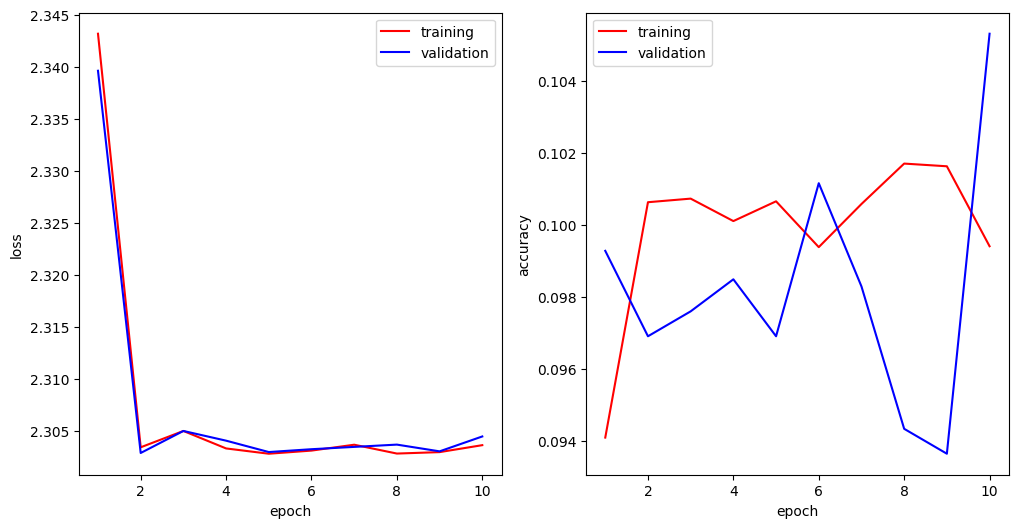

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 4998 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 2.3077, Accuracy = 0.0969
client 2 : Loss = 2.1519, Accuracy = 0.1746
client 3 : Loss = 2.2821, Accuracy = 0.1236
client 4 : Loss = 2.3115, Accuracy = 0.0963
client 5 : Loss = 2.1146, Accuracy = 0.1688
client 6 : Loss = 2.1479, Accuracy = 0.1843
client 7 : Loss = 2.1311, Accuracy = 0.1861
client 8 : Loss = 2.3078, Accuracy = 0.0982

Server :
    - training loss = 2.3244
    - training accuracy = 0.0987
    - validation loss = 2.3245
    - validation accuracy = 0.1031
        
>>> Round 2 ...
client 1 : Loss = 2.3087, Accuracy = 0.1013
client 2 : Loss = 2.1799, Accuracy = 0.1625
client 3 : Loss = 2.1570, Accuracy = 0.1669
client 4 : Loss = 2.0959, Accuracy = 0.1748
client 5 : Loss = 2.3143, Accuracy = 0.0973
client 6 : Loss = 2.3113, Accuracy = 0.0949
clie

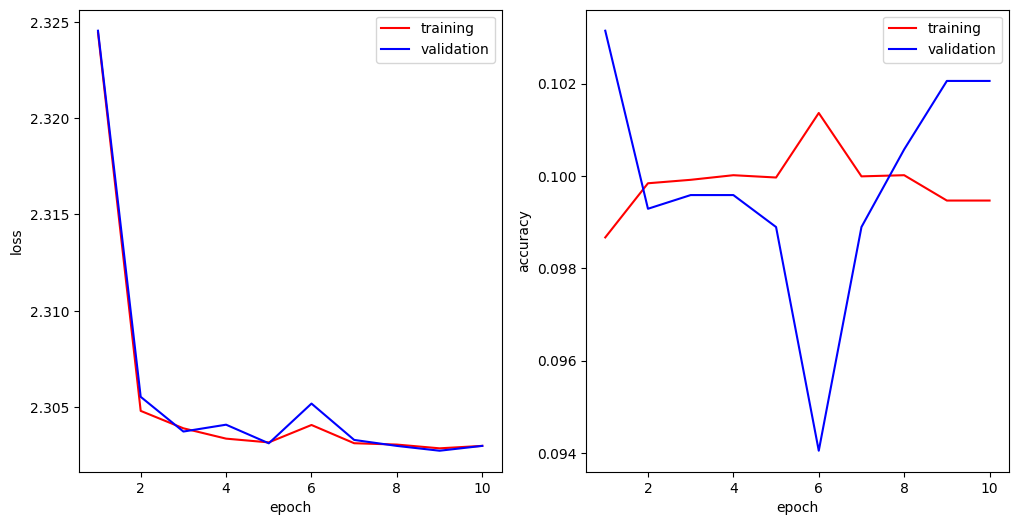

Fold #2
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4997 samples
client 4 : 5002 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 5000 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 2.1732, Accuracy = 0.1726
client 2 : Loss = 2.1720, Accuracy = 0.1681
client 3 : Loss = 2.1686, Accuracy = 0.1652
client 4 : Loss = 2.1713, Accuracy = 0.1661
client 5 : Loss = 2.3049, Accuracy = 0.1002
client 6 : Loss = 2.3114, Accuracy = 0.0893
client 7 : Loss = 2.1624, Accuracy = 0.1738
client 8 : Loss = 2.3145, Accuracy = 0.0934

Server :
    - training loss = 2.3290
    - training accuracy = 0.0998
    - validation loss = 2.3308
    - validation accuracy = 0.0972
        
>>> Round 2 ...
client 1 : Loss = 2.1300, Accuracy = 0.1617
client 2 : Loss = 2.3077, Accuracy = 0.0935
client 3 : Loss = 2.3099, Accuracy = 0.0951
client 4 : Loss = 2.0491, Accuracy = 0.1807
client 5 : Loss = 2.3103, Accuracy = 0.0951
client 6 : Loss = 2.3078, Accuracy = 0.1037
clie

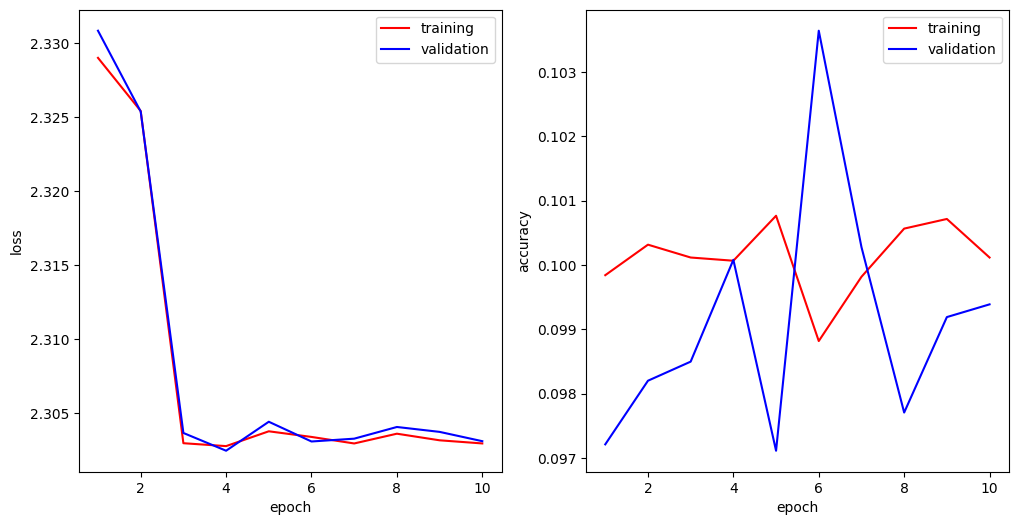

Fold #3
client 1 : 4999 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5001 samples
client 5 : 5000 samples
client 6 : 5000 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 2.1777, Accuracy = 0.1688
client 2 : Loss = 2.0718, Accuracy = 0.1965
client 3 : Loss = 2.3023, Accuracy = 0.1051
client 4 : Loss = 2.3016, Accuracy = 0.1043
client 5 : Loss = 2.2196, Accuracy = 0.1439
client 6 : Loss = 2.3006, Accuracy = 0.1330
client 7 : Loss = 2.0670, Accuracy = 0.1787
client 8 : Loss = 2.3102, Accuracy = 0.0932

Server :
    - training loss = 2.3145
    - training accuracy = 0.0986
    - validation loss = 2.3120
    - validation accuracy = 0.0990
        
>>> Round 2 ...
client 1 : Loss = 2.3093, Accuracy = 0.0948
client 2 : Loss = 2.3079, Accuracy = 0.0982
client 3 : Loss = 2.2560, Accuracy = 0.1328
client 4 : Loss = 2.3098, Accuracy = 0.0987
client 5 : Loss = 2.3116, Accuracy = 0.1000
client 6 : Loss = 2.3111, Accuracy = 0.0951
clie

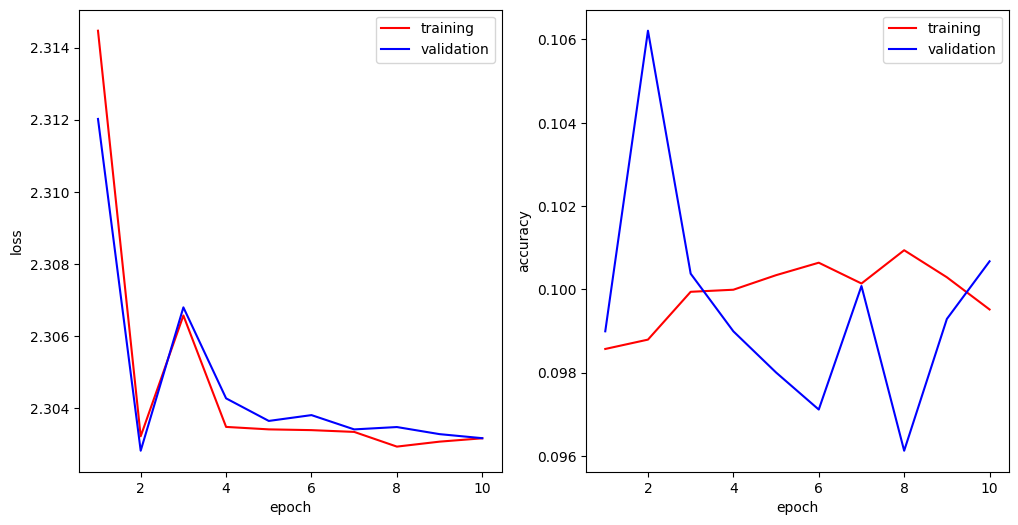

Fold #4
client 1 : 5001 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4998 samples
client 7 : 5000 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 2.0711, Accuracy = 0.1835
client 2 : Loss = 2.3085, Accuracy = 0.1016
client 3 : Loss = 2.3073, Accuracy = 0.1031
client 4 : Loss = 2.1964, Accuracy = 0.1525
client 5 : Loss = 2.3107, Accuracy = 0.0953
client 6 : Loss = 2.2903, Accuracy = 0.1102
client 7 : Loss = 2.1177, Accuracy = 0.1971
client 8 : Loss = 2.1063, Accuracy = 0.1856

Server :
    - training loss = 2.3232
    - training accuracy = 0.1001
    - validation loss = 2.3234
    - validation accuracy = 0.1002
        
>>> Round 2 ...
client 1 : Loss = 2.0866, Accuracy = 0.1681
client 2 : Loss = 2.0601, Accuracy = 0.1645
client 3 : Loss = 2.1173, Accuracy = 0.1697
client 4 : Loss = 2.1127, Accuracy = 0.1652
client 5 : Loss = 2.1046, Accuracy = 0.1533
client 6 : Loss = 2.3093, Accuracy = 0.0969
clie

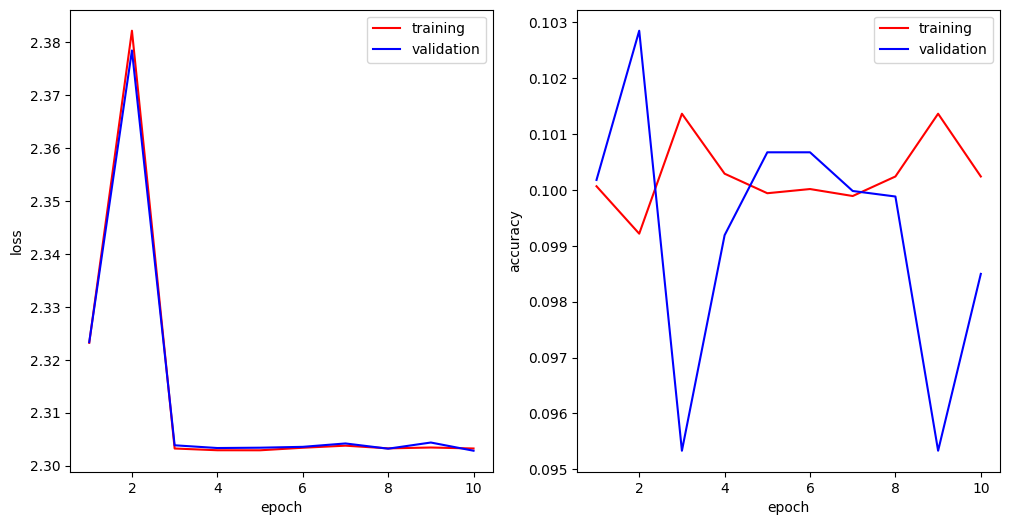

Fold #0
client 1 : 5000 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 4999 samples
client 5 : 5002 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.6256, Accuracy = 0.4201
client 2 : Loss = 1.5791, Accuracy = 0.4525
client 3 : Loss = 1.7105, Accuracy = 0.4127
client 4 : Loss = 1.6645, Accuracy = 0.4228
client 5 : Loss = 1.6891, Accuracy = 0.4236
client 6 : Loss = 1.8299, Accuracy = 0.3867
client 7 : Loss = 1.6795, Accuracy = 0.4019
client 8 : Loss = 1.7129, Accuracy = 0.4032

Server :
    - training loss = 2.0060
    - training accuracy = 0.3037
    - validation loss = 1.9983
    - validation accuracy = 0.2992
        
>>> Round 2 ...
client 1 : Loss = 1.3772, Accuracy = 0.4795
client 2 : Loss = 1.3387, Accuracy = 0.5137
client 3 : Loss = 1.3910, Accuracy = 0.4903
client 4 : Loss = 1.3767, Accuracy = 0.4991
client 5 : Loss = 1.3974, Accuracy = 0.4977
client 6 : Loss = 1.3545, Accuracy = 0.5139
clie

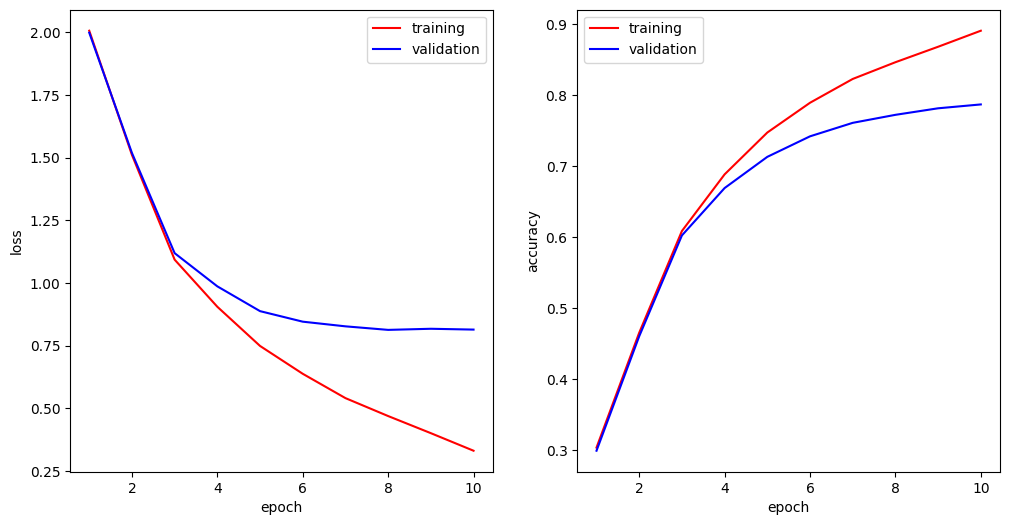

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 4998 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 1.5229, Accuracy = 0.4534
client 2 : Loss = 1.7593, Accuracy = 0.3894
client 3 : Loss = 1.6831, Accuracy = 0.4068
client 4 : Loss = 1.7248, Accuracy = 0.4141
client 5 : Loss = 1.6108, Accuracy = 0.4234
client 6 : Loss = 1.6616, Accuracy = 0.4058
client 7 : Loss = 1.7810, Accuracy = 0.3923
client 8 : Loss = 1.4748, Accuracy = 0.4670

Server :
    - training loss = 1.8506
    - training accuracy = 0.3278
    - validation loss = 1.8525
    - validation accuracy = 0.3258
        
>>> Round 2 ...
client 1 : Loss = 1.2686, Accuracy = 0.5396
client 2 : Loss = 1.5281, Accuracy = 0.4569
client 3 : Loss = 1.3662, Accuracy = 0.4992
client 4 : Loss = 1.2829, Accuracy = 0.5342
client 5 : Loss = 1.3825, Accuracy = 0.5072
client 6 : Loss = 1.3468, Accuracy = 0.5162
clie

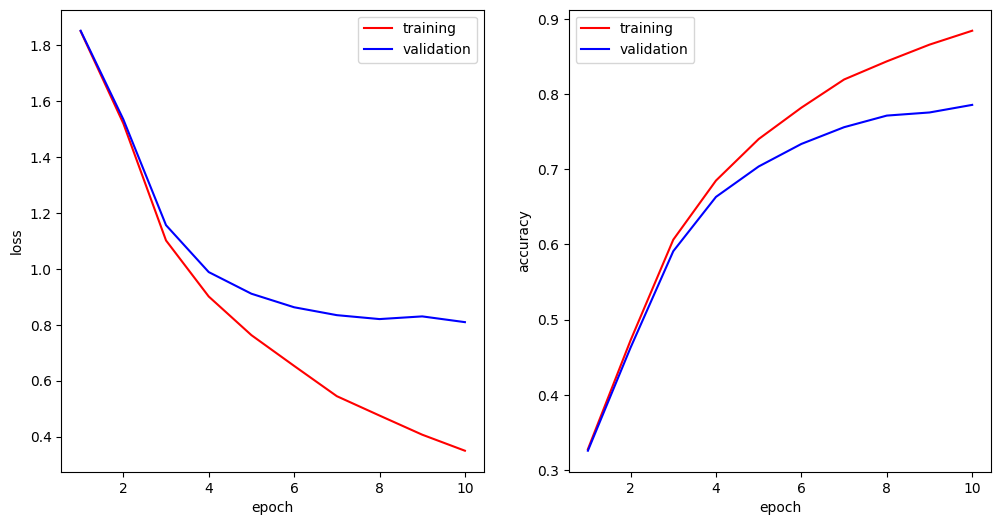

Fold #2
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4997 samples
client 4 : 5002 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 5000 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.6158, Accuracy = 0.4349
client 2 : Loss = 1.5422, Accuracy = 0.4443
client 3 : Loss = 1.7138, Accuracy = 0.3898
client 4 : Loss = 1.6752, Accuracy = 0.4073
client 5 : Loss = 1.7021, Accuracy = 0.4303
client 6 : Loss = 1.8094, Accuracy = 0.3912
client 7 : Loss = 1.8080, Accuracy = 0.3684
client 8 : Loss = 1.6933, Accuracy = 0.4135

Server :
    - training loss = 1.8474
    - training accuracy = 0.3311
    - validation loss = 1.8519
    - validation accuracy = 0.3254
        
>>> Round 2 ...
client 1 : Loss = 1.3244, Accuracy = 0.5172
client 2 : Loss = 1.3326, Accuracy = 0.5273
client 3 : Loss = 1.3691, Accuracy = 0.5036
client 4 : Loss = 1.3354, Accuracy = 0.5056
client 5 : Loss = 1.2516, Accuracy = 0.5406
client 6 : Loss = 1.3108, Accuracy = 0.5142
clie

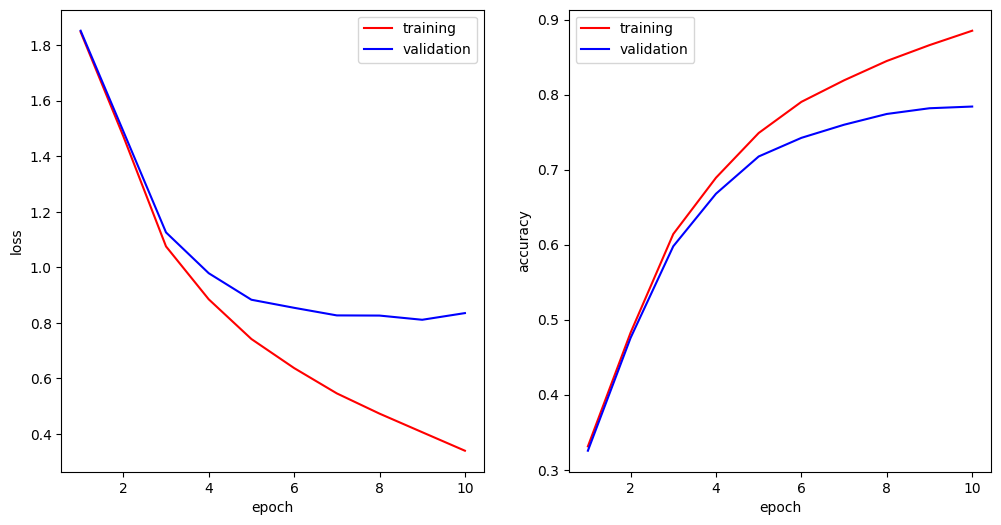

Fold #3
client 1 : 4999 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5001 samples
client 5 : 5000 samples
client 6 : 5000 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.5436, Accuracy = 0.4374
client 2 : Loss = 1.6190, Accuracy = 0.4397
client 3 : Loss = 1.5512, Accuracy = 0.4357
client 4 : Loss = 1.5803, Accuracy = 0.4397
client 5 : Loss = 1.6219, Accuracy = 0.4187
client 6 : Loss = 1.6017, Accuracy = 0.4445
client 7 : Loss = 1.4780, Accuracy = 0.4715
client 8 : Loss = 1.6713, Accuracy = 0.4013

Server :
    - training loss = 1.9591
    - training accuracy = 0.3150
    - validation loss = 1.9605
    - validation accuracy = 0.3087
        
>>> Round 2 ...
client 1 : Loss = 1.3479, Accuracy = 0.5105
client 2 : Loss = 1.3479, Accuracy = 0.5084
client 3 : Loss = 1.3234, Accuracy = 0.5203
client 4 : Loss = 1.2577, Accuracy = 0.5468
client 5 : Loss = 1.2722, Accuracy = 0.5350
client 6 : Loss = 1.2764, Accuracy = 0.5305
clie

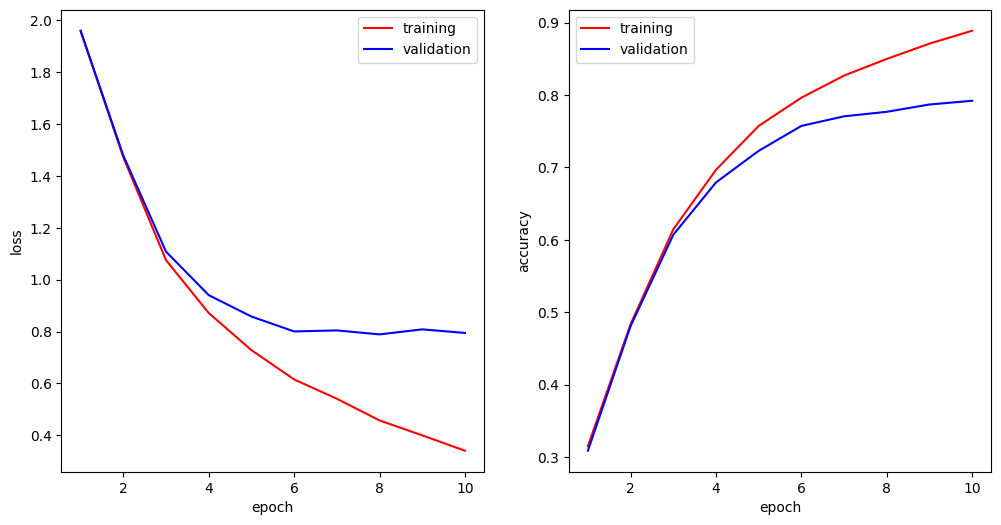

Fold #4
client 1 : 5001 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4998 samples
client 7 : 5000 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.5046, Accuracy = 0.4639
client 2 : Loss = 1.7077, Accuracy = 0.3935
client 3 : Loss = 1.5986, Accuracy = 0.4369
client 4 : Loss = 1.5141, Accuracy = 0.4514
client 5 : Loss = 1.4785, Accuracy = 0.4557
client 6 : Loss = 1.5770, Accuracy = 0.4365
client 7 : Loss = 1.5248, Accuracy = 0.4426
client 8 : Loss = 1.6115, Accuracy = 0.4245

Server :
    - training loss = 1.7359
    - training accuracy = 0.3761
    - validation loss = 1.7423
    - validation accuracy = 0.3735
        
>>> Round 2 ...
client 1 : Loss = 1.2246, Accuracy = 0.5556
client 2 : Loss = 1.2975, Accuracy = 0.5306
client 3 : Loss = 1.3302, Accuracy = 0.5201
client 4 : Loss = 1.3171, Accuracy = 0.5160
client 5 : Loss = 1.3136, Accuracy = 0.5218
client 6 : Loss = 1.3181, Accuracy = 0.5325
clie

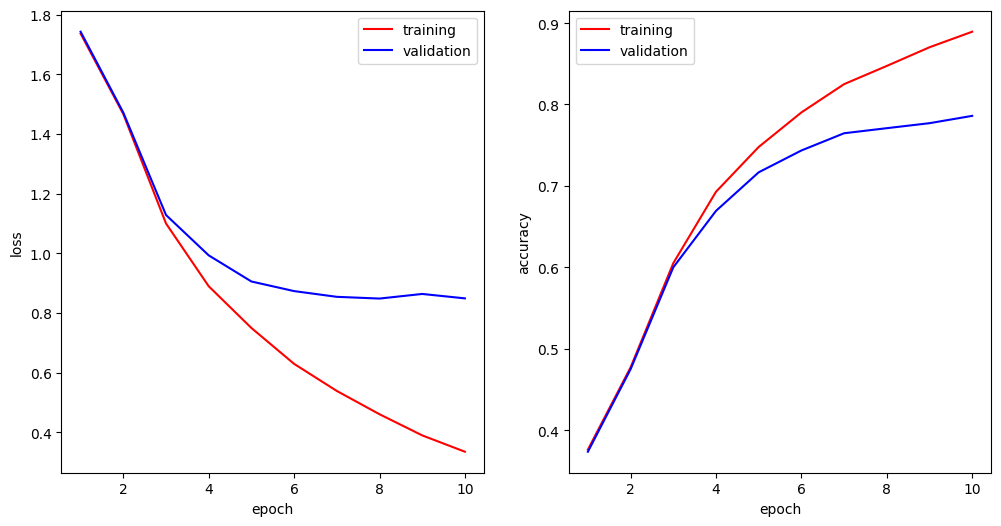

Fold #0
client 1 : 5000 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 4999 samples
client 5 : 5002 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.0022, Accuracy = 0.6492
client 2 : Loss = 1.0015, Accuracy = 0.6476
client 3 : Loss = 1.0524, Accuracy = 0.6330
client 4 : Loss = 1.1908, Accuracy = 0.5828
client 5 : Loss = 1.0008, Accuracy = 0.6461
client 6 : Loss = 1.0345, Accuracy = 0.6325
client 7 : Loss = 1.0201, Accuracy = 0.6338
client 8 : Loss = 1.0149, Accuracy = 0.6451

Server :
    - training loss = 1.2935
    - training accuracy = 0.5542
    - validation loss = 1.3312
    - validation accuracy = 0.5281
        
>>> Round 2 ...
client 1 : Loss = 0.5335, Accuracy = 0.8258
client 2 : Loss = 0.5751, Accuracy = 0.8059
client 3 : Loss = 0.6450, Accuracy = 0.7683
client 4 : Loss = 0.6866, Accuracy = 0.7566
client 5 : Loss = 0.5299, Accuracy = 0.8164
client 6 : Loss = 0.6762, Accuracy = 0.7651
clie

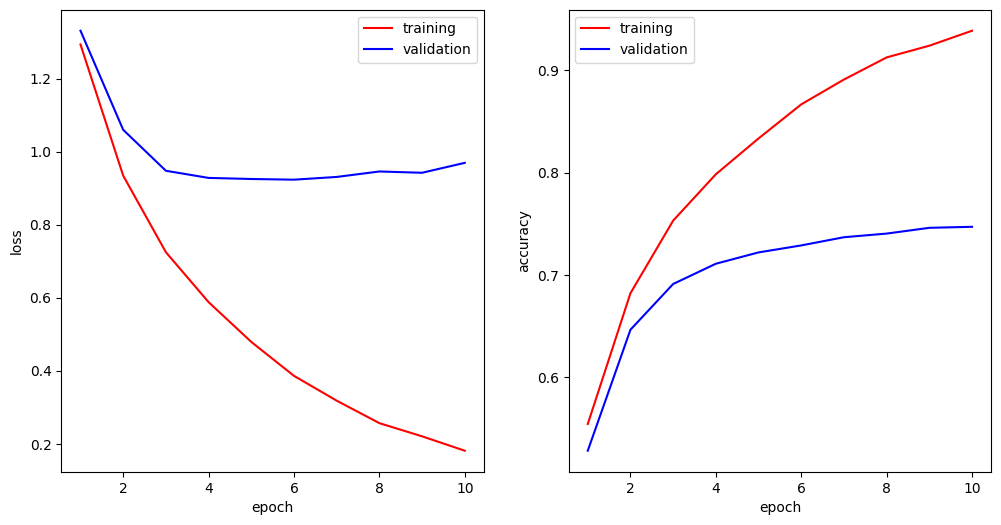

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 4998 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 1.0096, Accuracy = 0.6472
client 2 : Loss = 1.1221, Accuracy = 0.6013
client 3 : Loss = 1.0279, Accuracy = 0.6317
client 4 : Loss = 1.0447, Accuracy = 0.6277
client 5 : Loss = 1.0134, Accuracy = 0.6419
client 6 : Loss = 0.9883, Accuracy = 0.6499
client 7 : Loss = 1.0857, Accuracy = 0.6182
client 8 : Loss = 1.0992, Accuracy = 0.6101

Server :
    - training loss = 1.2853
    - training accuracy = 0.5530
    - validation loss = 1.3564
    - validation accuracy = 0.5368
        
>>> Round 2 ...
client 1 : Loss = 0.5210, Accuracy = 0.8374
client 2 : Loss = 0.6398, Accuracy = 0.7777
client 3 : Loss = 0.6038, Accuracy = 0.7979
client 4 : Loss = 0.6311, Accuracy = 0.7734
client 5 : Loss = 0.5963, Accuracy = 0.8056
client 6 : Loss = 0.6169, Accuracy = 0.7791
clie

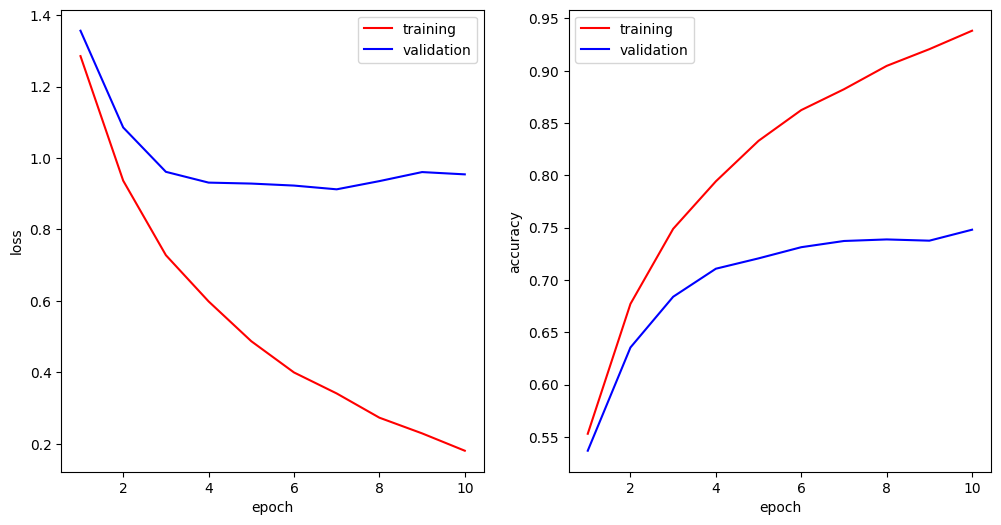

Fold #2
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4997 samples
client 4 : 5002 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 5000 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.0491, Accuracy = 0.6325
client 2 : Loss = 1.0525, Accuracy = 0.6221
client 3 : Loss = 1.0110, Accuracy = 0.6425
client 4 : Loss = 0.9744, Accuracy = 0.6540
client 5 : Loss = 0.9940, Accuracy = 0.6508
client 6 : Loss = 1.0101, Accuracy = 0.6423
client 7 : Loss = 1.0630, Accuracy = 0.6135
client 8 : Loss = 0.9733, Accuracy = 0.6463

Server :
    - training loss = 1.2884
    - training accuracy = 0.5503
    - validation loss = 1.3616
    - validation accuracy = 0.5350
        
>>> Round 2 ...
client 1 : Loss = 0.6989, Accuracy = 0.7535
client 2 : Loss = 0.5361, Accuracy = 0.8216
client 3 : Loss = 0.6549, Accuracy = 0.7739
client 4 : Loss = 0.5334, Accuracy = 0.8262
client 5 : Loss = 0.6320, Accuracy = 0.7857
client 6 : Loss = 0.6016, Accuracy = 0.7987
clie

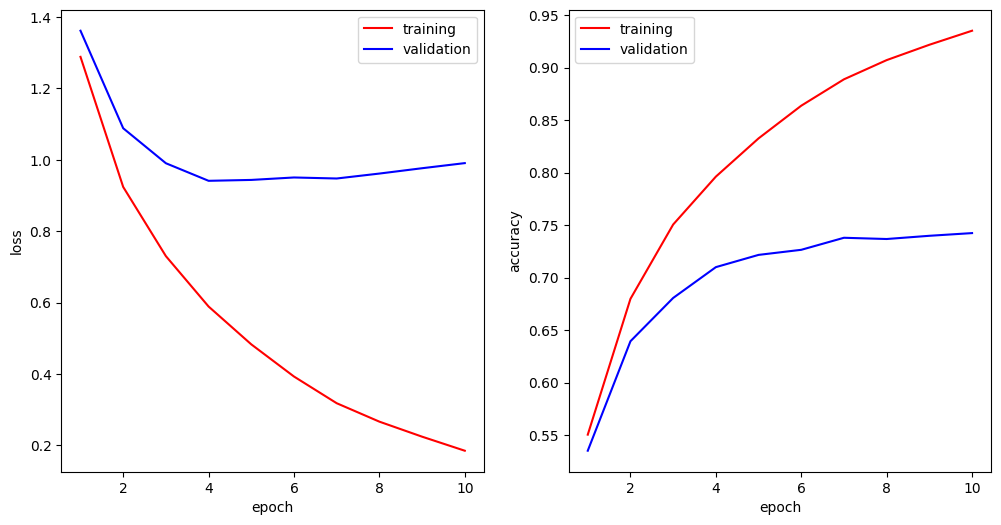

Fold #3
client 1 : 4999 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5001 samples
client 5 : 5000 samples
client 6 : 5000 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.0163, Accuracy = 0.6395
client 2 : Loss = 0.9973, Accuracy = 0.6486
client 3 : Loss = 1.0162, Accuracy = 0.6400
client 4 : Loss = 1.0035, Accuracy = 0.6472
client 5 : Loss = 1.0593, Accuracy = 0.6346
client 6 : Loss = 1.0217, Accuracy = 0.6402
client 7 : Loss = 1.0632, Accuracy = 0.6161
client 8 : Loss = 0.9846, Accuracy = 0.6514

Server :
    - training loss = 1.3012
    - training accuracy = 0.5497
    - validation loss = 1.3394
    - validation accuracy = 0.5399
        
>>> Round 2 ...
client 1 : Loss = 0.6503, Accuracy = 0.7811
client 2 : Loss = 0.5295, Accuracy = 0.8232
client 3 : Loss = 0.6510, Accuracy = 0.7777
client 4 : Loss = 0.5905, Accuracy = 0.7998
client 5 : Loss = 0.6371, Accuracy = 0.7881
client 6 : Loss = 0.6474, Accuracy = 0.7783
clie

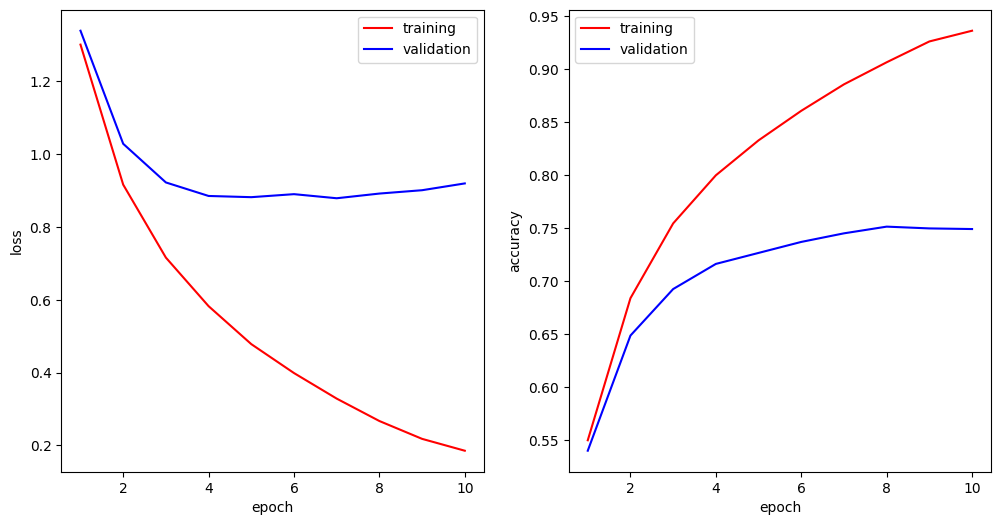

Fold #4
client 1 : 5001 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4998 samples
client 7 : 5000 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.0154, Accuracy = 0.6383
client 2 : Loss = 1.0623, Accuracy = 0.6168
client 3 : Loss = 1.0124, Accuracy = 0.6361
client 4 : Loss = 1.0930, Accuracy = 0.6064
client 5 : Loss = 0.9846, Accuracy = 0.6553
client 6 : Loss = 1.0724, Accuracy = 0.6280
client 7 : Loss = 1.0498, Accuracy = 0.6285
client 8 : Loss = 0.9878, Accuracy = 0.6516

Server :
    - training loss = 1.2888
    - training accuracy = 0.5512
    - validation loss = 1.3652
    - validation accuracy = 0.5312
        
>>> Round 2 ...
client 1 : Loss = 0.5659, Accuracy = 0.8039
client 2 : Loss = 0.5614, Accuracy = 0.8138
client 3 : Loss = 0.6240, Accuracy = 0.7887
client 4 : Loss = 0.6480, Accuracy = 0.7834
client 5 : Loss = 0.5905, Accuracy = 0.7994
client 6 : Loss = 0.6401, Accuracy = 0.7815
clie

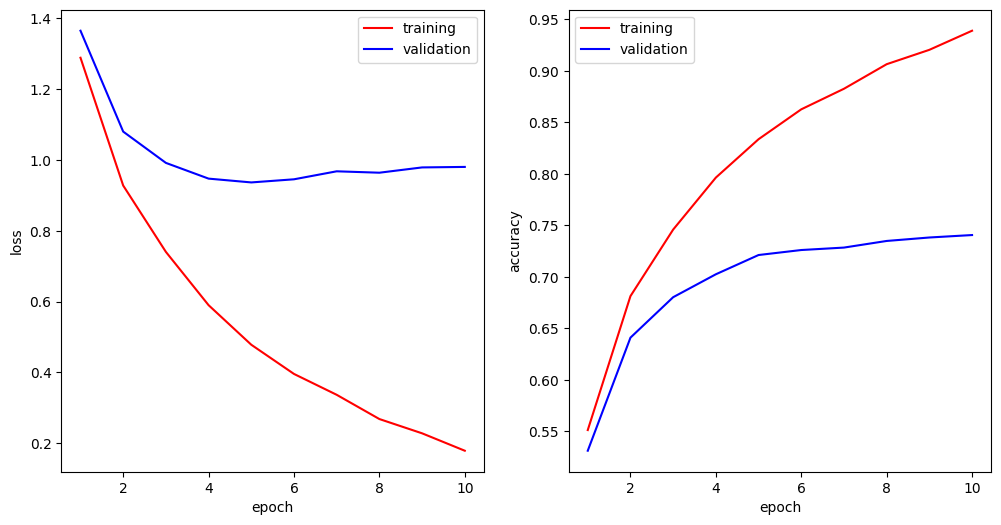

Fold #0
client 1 : 5000 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 4999 samples
client 5 : 5002 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.3535, Accuracy = 0.5215
client 2 : Loss = 1.3680, Accuracy = 0.5210
client 3 : Loss = 1.3707, Accuracy = 0.5140
client 4 : Loss = 1.3579, Accuracy = 0.5298
client 5 : Loss = 1.3314, Accuracy = 0.5316
client 6 : Loss = 1.3792, Accuracy = 0.5147
client 7 : Loss = 1.3732, Accuracy = 0.5184
client 8 : Loss = 1.3990, Accuracy = 0.5117

Server :
    - training loss = 1.4551
    - training accuracy = 0.4805
    - validation loss = 1.5248
    - validation accuracy = 0.4478
        
>>> Round 2 ...
client 1 : Loss = 1.0667, Accuracy = 0.6316
client 2 : Loss = 1.0859, Accuracy = 0.6184
client 3 : Loss = 1.1228, Accuracy = 0.6105
client 4 : Loss = 1.1305, Accuracy = 0.6051
client 5 : Loss = 1.0408, Accuracy = 0.6384
client 6 : Loss = 1.1297, Accuracy = 0.5992
clie

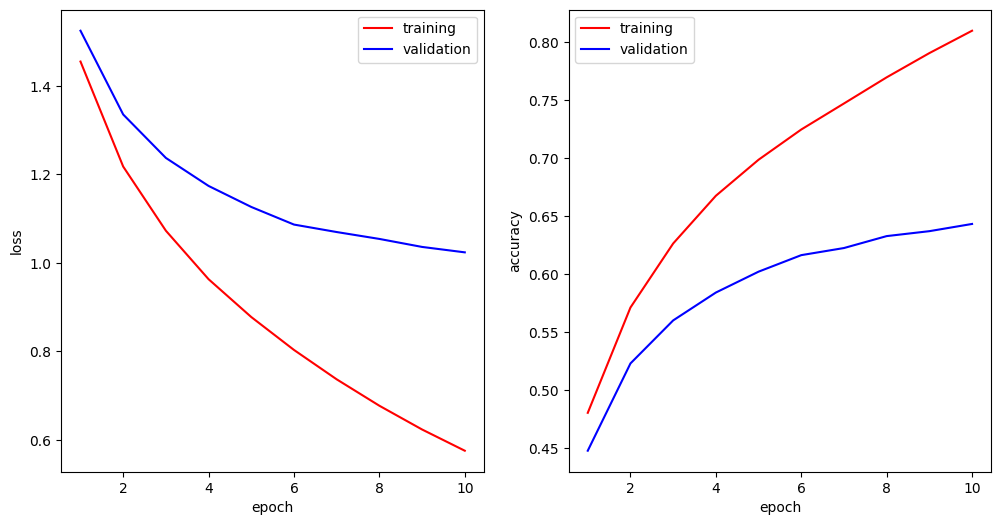

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 4998 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 1.3782, Accuracy = 0.5157
client 2 : Loss = 1.4661, Accuracy = 0.4873
client 3 : Loss = 1.4359, Accuracy = 0.4890
client 4 : Loss = 1.3942, Accuracy = 0.5055
client 5 : Loss = 1.3633, Accuracy = 0.5210
client 6 : Loss = 1.4442, Accuracy = 0.4902
client 7 : Loss = 1.4157, Accuracy = 0.5090
client 8 : Loss = 1.4078, Accuracy = 0.5053

Server :
    - training loss = 1.4822
    - training accuracy = 0.4761
    - validation loss = 1.5646
    - validation accuracy = 0.4462
        
>>> Round 2 ...
client 1 : Loss = 1.1141, Accuracy = 0.6051
client 2 : Loss = 1.1314, Accuracy = 0.5943
client 3 : Loss = 1.1393, Accuracy = 0.6019
client 4 : Loss = 1.1052, Accuracy = 0.6076
client 5 : Loss = 1.1055, Accuracy = 0.6087
client 6 : Loss = 1.1682, Accuracy = 0.5828
clie

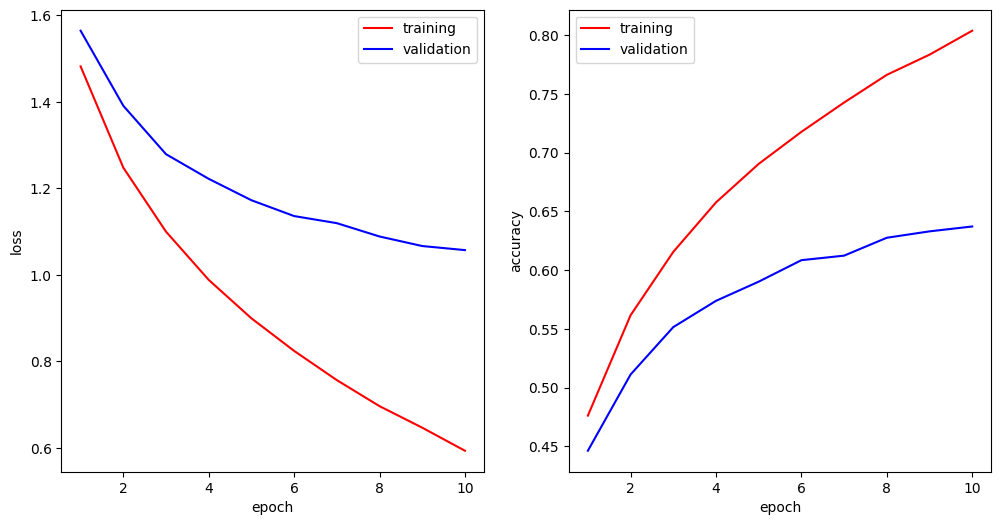

Fold #2
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4997 samples
client 4 : 5002 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 5000 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.4392, Accuracy = 0.4878
client 2 : Loss = 1.3646, Accuracy = 0.5175
client 3 : Loss = 1.4236, Accuracy = 0.5108
client 4 : Loss = 1.4261, Accuracy = 0.5050
client 5 : Loss = 1.4282, Accuracy = 0.4895
client 6 : Loss = 1.3858, Accuracy = 0.5153
client 7 : Loss = 1.4348, Accuracy = 0.4865
client 8 : Loss = 1.4138, Accuracy = 0.5055

Server :
    - training loss = 1.4823
    - training accuracy = 0.4710
    - validation loss = 1.5581
    - validation accuracy = 0.4393
        
>>> Round 2 ...
client 1 : Loss = 1.1179, Accuracy = 0.6048
client 2 : Loss = 1.1287, Accuracy = 0.5993
client 3 : Loss = 1.1678, Accuracy = 0.5885
client 4 : Loss = 1.1508, Accuracy = 0.5968
client 5 : Loss = 1.1604, Accuracy = 0.5818
client 6 : Loss = 1.1481, Accuracy = 0.6053
clie

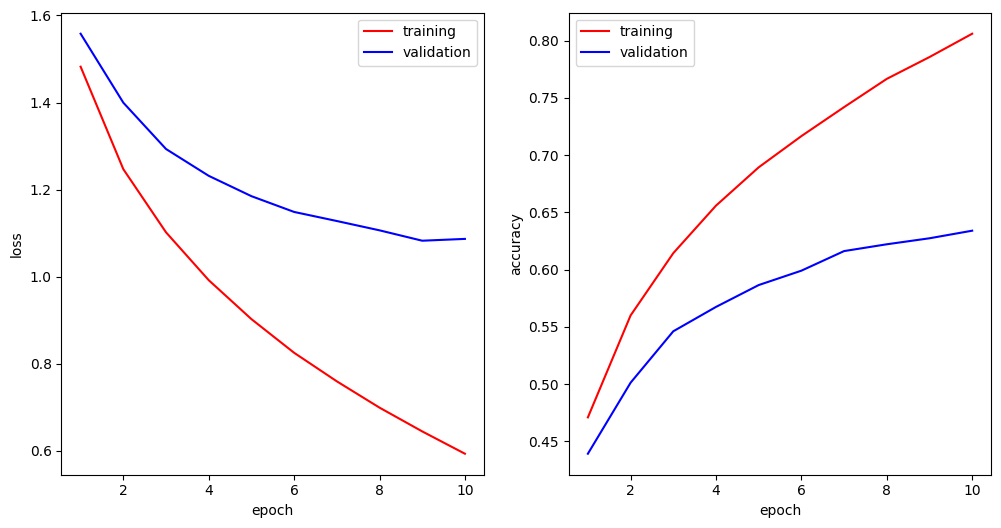

Fold #3
client 1 : 4999 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5001 samples
client 5 : 5000 samples
client 6 : 5000 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.3908, Accuracy = 0.5034
client 2 : Loss = 1.3711, Accuracy = 0.5132
client 3 : Loss = 1.4069, Accuracy = 0.5079
client 4 : Loss = 1.4269, Accuracy = 0.5049
client 5 : Loss = 1.4170, Accuracy = 0.5039
client 6 : Loss = 1.3831, Accuracy = 0.5082
client 7 : Loss = 1.3811, Accuracy = 0.5074
client 8 : Loss = 1.3830, Accuracy = 0.5091

Server :
    - training loss = 1.4849
    - training accuracy = 0.4714
    - validation loss = 1.5683
    - validation accuracy = 0.4449
        
>>> Round 2 ...
client 1 : Loss = 1.1294, Accuracy = 0.6043
client 2 : Loss = 1.1184, Accuracy = 0.6158
client 3 : Loss = 1.1334, Accuracy = 0.6056
client 4 : Loss = 1.1314, Accuracy = 0.6057
client 5 : Loss = 1.1276, Accuracy = 0.5947
client 6 : Loss = 1.1232, Accuracy = 0.6029
clie

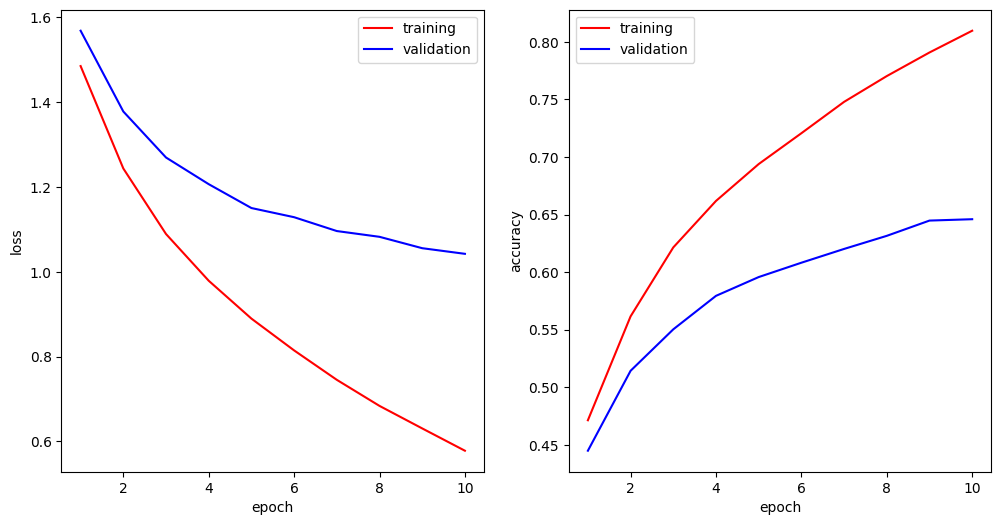

Fold #4
client 1 : 5001 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4998 samples
client 7 : 5000 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.3998, Accuracy = 0.5049
client 2 : Loss = 1.3863, Accuracy = 0.5188
client 3 : Loss = 1.3791, Accuracy = 0.5027
client 4 : Loss = 1.3913, Accuracy = 0.5029
client 5 : Loss = 1.3810, Accuracy = 0.5185
client 6 : Loss = 1.3845, Accuracy = 0.5143
client 7 : Loss = 1.3827, Accuracy = 0.5109
client 8 : Loss = 1.3882, Accuracy = 0.5094

Server :
    - training loss = 1.4752
    - training accuracy = 0.4737
    - validation loss = 1.5575
    - validation accuracy = 0.4411
        
>>> Round 2 ...
client 1 : Loss = 1.1170, Accuracy = 0.6126
client 2 : Loss = 1.1245, Accuracy = 0.6049
client 3 : Loss = 1.1279, Accuracy = 0.6027
client 4 : Loss = 1.1560, Accuracy = 0.6002
client 5 : Loss = 1.1464, Accuracy = 0.5976
client 6 : Loss = 1.1236, Accuracy = 0.6059
clie

In [ ]:
%%time
n_splits = 5
rounds = 10
batch_size = 128
epochs = 5
lrs = [1e-1,1e-2,1e-3,1e-4]
optimizer = optim.Adam

results = []
for lr in lrs:
    res = run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr)
    results.append((lr,res))
    
print("="*25)
print(f"RESULTS")
print("="*25)
for lr,res in results:
    print(f"lr = {lr:.4f} : Accuracy = {res}")
print()


### Comment: It can be seen that best learning rates are 0.001 and 0.01. Let's try to check for value in between these values, 0.005:

Fold #0
client 1 : 5000 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5000 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.8350, Accuracy = 0.3582
client 2 : Loss = 1.6475, Accuracy = 0.4217
client 3 : Loss = 1.7067, Accuracy = 0.4269
client 4 : Loss = 1.8782, Accuracy = 0.3406
client 5 : Loss = 1.7264, Accuracy = 0.4056
client 6 : Loss = 1.7385, Accuracy = 0.3873
client 7 : Loss = 1.7662, Accuracy = 0.3984
client 8 : Loss = 1.7014, Accuracy = 0.4127

Server :
    - training loss = 1.9459
    - training accuracy = 0.3173
    - validation loss = 1.9398
    - validation accuracy = 0.3170
        
>>> Round 2 ...
client 1 : Loss = 1.3619, Accuracy = 0.5084
client 2 : Loss = 1.3395, Accuracy = 0.5252
client 3 : Loss = 1.2889, Accuracy = 0.5289
client 4 : Loss = 1.3441, Accuracy = 0.5086
client 5 : Loss = 1.3879, Accuracy = 0.4951
client 6 : Loss = 1.3600, Accuracy = 0.5027
clie

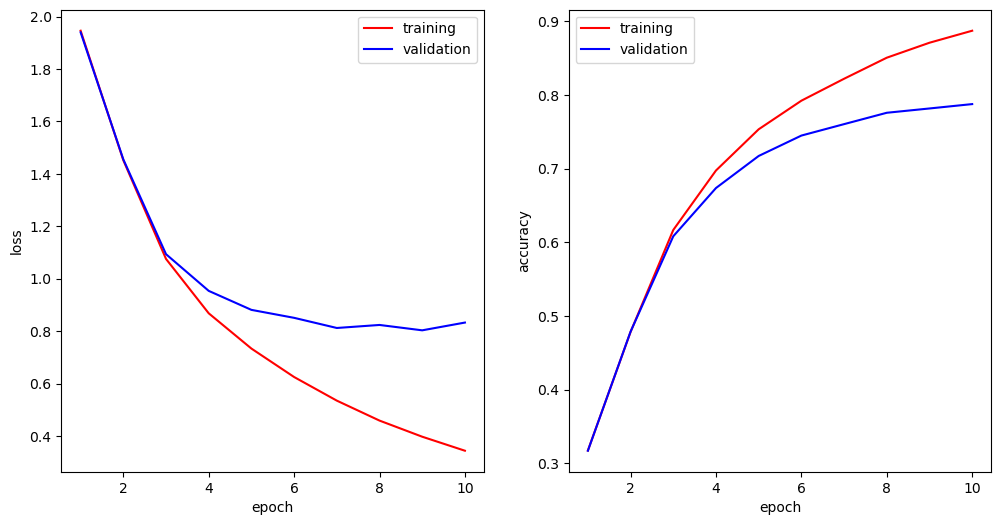

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5001 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 4998 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 1.7053, Accuracy = 0.3982
client 2 : Loss = 1.5561, Accuracy = 0.4476
client 3 : Loss = 1.6214, Accuracy = 0.4354
client 4 : Loss = 1.5516, Accuracy = 0.4300
client 5 : Loss = 1.5313, Accuracy = 0.4430
client 6 : Loss = 1.6400, Accuracy = 0.4194
client 7 : Loss = 1.5292, Accuracy = 0.4593
client 8 : Loss = 1.5588, Accuracy = 0.4523

Server :
    - training loss = 1.8032
    - training accuracy = 0.3720
    - validation loss = 1.8083
    - validation accuracy = 0.3607
        
>>> Round 2 ...
client 1 : Loss = 1.2954, Accuracy = 0.5293
client 2 : Loss = 1.3099, Accuracy = 0.5315
client 3 : Loss = 1.2957, Accuracy = 0.5269
client 4 : Loss = 1.2588, Accuracy = 0.5494
client 5 : Loss = 1.2556, Accuracy = 0.5484
client 6 : Loss = 1.4479, Accuracy = 0.4717
clie

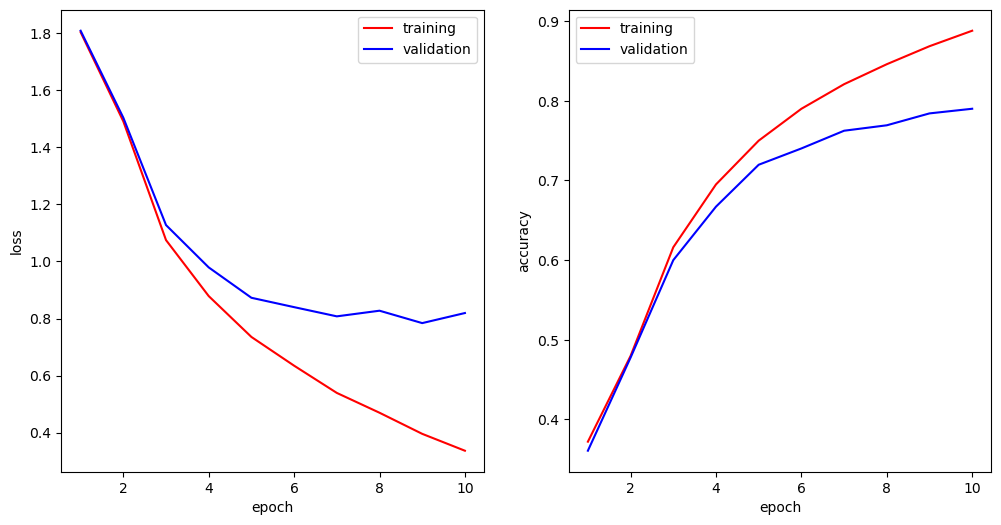

Fold #2
client 1 : 5000 samples
client 2 : 5001 samples
client 3 : 4998 samples
client 4 : 5001 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5000 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.7265, Accuracy = 0.3982
client 2 : Loss = 1.5292, Accuracy = 0.4585
client 3 : Loss = 1.7648, Accuracy = 0.3847
client 4 : Loss = 1.5597, Accuracy = 0.4289
client 5 : Loss = 1.5015, Accuracy = 0.4658
client 6 : Loss = 1.6379, Accuracy = 0.4172
client 7 : Loss = 1.5136, Accuracy = 0.4506
client 8 : Loss = 1.6557, Accuracy = 0.4144

Server :
    - training loss = 1.8422
    - training accuracy = 0.3178
    - validation loss = 1.8408
    - validation accuracy = 0.3093
        
>>> Round 2 ...
client 1 : Loss = 1.3283, Accuracy = 0.5281
client 2 : Loss = 1.3281, Accuracy = 0.5167
client 3 : Loss = 1.3089, Accuracy = 0.5131
client 4 : Loss = 1.3005, Accuracy = 0.5263
client 5 : Loss = 1.2197, Accuracy = 0.5505
client 6 : Loss = 1.2537, Accuracy = 0.5502
clie

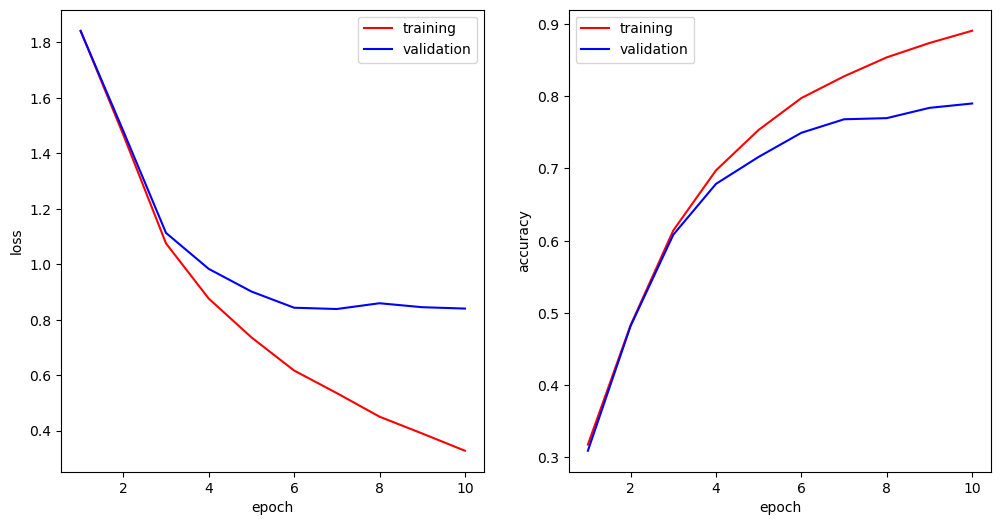

Fold #3
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 5003 samples
client 5 : 4997 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.6682, Accuracy = 0.4172
client 2 : Loss = 1.7348, Accuracy = 0.4064
client 3 : Loss = 1.7309, Accuracy = 0.3842
client 4 : Loss = 1.6638, Accuracy = 0.4040
client 5 : Loss = 1.5953, Accuracy = 0.4385
client 6 : Loss = 1.5678, Accuracy = 0.4329
client 7 : Loss = 1.5298, Accuracy = 0.4565
client 8 : Loss = 1.6576, Accuracy = 0.4133

Server :
    - training loss = 1.8498
    - training accuracy = 0.3500
    - validation loss = 1.8582
    - validation accuracy = 0.3482
        
>>> Round 2 ...
client 1 : Loss = 1.2878, Accuracy = 0.5398
client 2 : Loss = 1.3396, Accuracy = 0.5131
client 3 : Loss = 1.3385, Accuracy = 0.5191
client 4 : Loss = 1.3275, Accuracy = 0.5206
client 5 : Loss = 1.4820, Accuracy = 0.4691
client 6 : Loss = 1.3579, Accuracy = 0.5063
clie

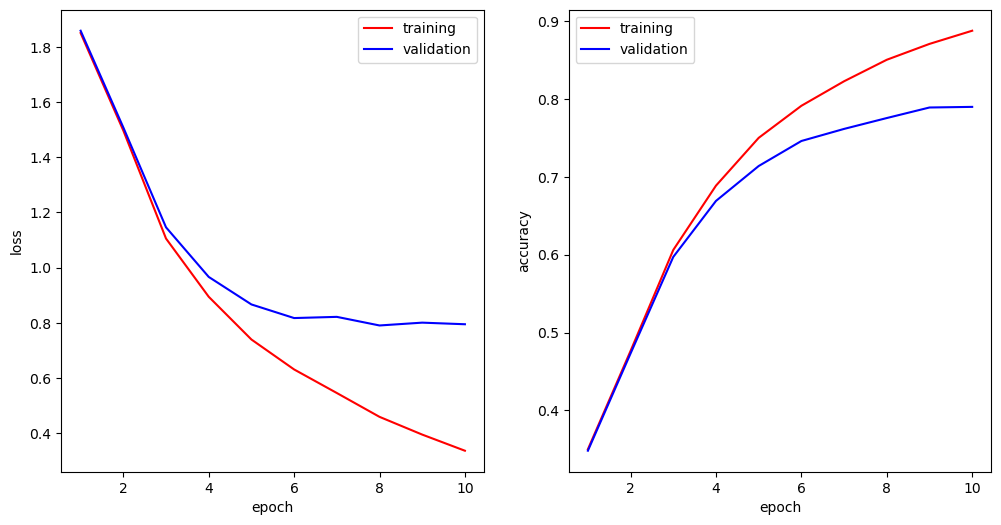

Fold #4
client 1 : 5001 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 5000 samples
client 5 : 4999 samples
client 6 : 5000 samples
client 7 : 4999 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.6154, Accuracy = 0.4234
client 2 : Loss = 1.6258, Accuracy = 0.4201
client 3 : Loss = 1.7441, Accuracy = 0.4021
client 4 : Loss = 1.7919, Accuracy = 0.4109
client 5 : Loss = 1.6416, Accuracy = 0.4230
client 6 : Loss = 1.6402, Accuracy = 0.4068
client 7 : Loss = 1.8319, Accuracy = 0.3607
client 8 : Loss = 1.5916, Accuracy = 0.4275

Server :
    - training loss = 1.8622
    - training accuracy = 0.3236
    - validation loss = 1.8784
    - validation accuracy = 0.3188
        
>>> Round 2 ...
client 1 : Loss = 1.4255, Accuracy = 0.4883
client 2 : Loss = 1.4910, Accuracy = 0.4447
client 3 : Loss = 1.4551, Accuracy = 0.4742
client 4 : Loss = 1.3878, Accuracy = 0.4947
client 5 : Loss = 1.3603, Accuracy = 0.5049
client 6 : Loss = 1.3588, Accuracy = 0.5066
clie

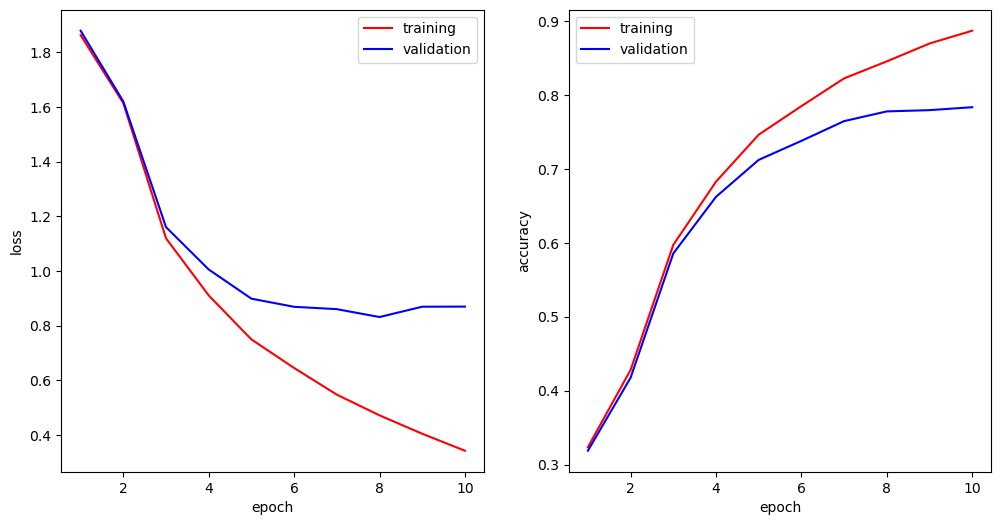

Fold #0
client 1 : 5000 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5000 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.4367, Accuracy = 0.4850
client 2 : Loss = 1.4626, Accuracy = 0.4768
client 3 : Loss = 1.3291, Accuracy = 0.5193
client 4 : Loss = 1.4605, Accuracy = 0.4910
client 5 : Loss = 1.3941, Accuracy = 0.5108
client 6 : Loss = 1.4134, Accuracy = 0.5111
client 7 : Loss = 1.3676, Accuracy = 0.5141
client 8 : Loss = 1.4433, Accuracy = 0.4853

Server :
    - training loss = 1.5740
    - training accuracy = 0.4386
    - validation loss = 1.5880
    - validation accuracy = 0.4308
        
>>> Round 2 ...
client 1 : Loss = 1.0672, Accuracy = 0.6242
client 2 : Loss = 1.0839, Accuracy = 0.6085
client 3 : Loss = 1.0957, Accuracy = 0.6069
client 4 : Loss = 1.0583, Accuracy = 0.6238
client 5 : Loss = 1.1608, Accuracy = 0.5833
client 6 : Loss = 1.1676, Accuracy = 0.5820
clie

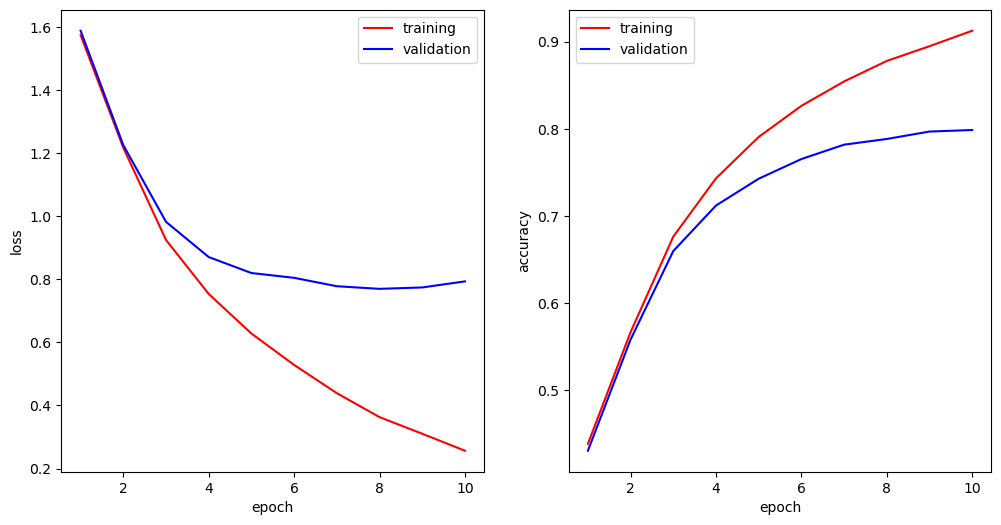

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5001 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 4998 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 1.3891, Accuracy = 0.5094
client 2 : Loss = 1.5263, Accuracy = 0.4612
client 3 : Loss = 1.4186, Accuracy = 0.4947
client 4 : Loss = 1.3196, Accuracy = 0.5296
client 5 : Loss = 1.5152, Accuracy = 0.4680
client 6 : Loss = 1.3471, Accuracy = 0.5285
client 7 : Loss = 1.4974, Accuracy = 0.4775
client 8 : Loss = 1.2946, Accuracy = 0.5353

Server :
    - training loss = 1.4988
    - training accuracy = 0.4609
    - validation loss = 1.5086
    - validation accuracy = 0.4586
        
>>> Round 2 ...
client 1 : Loss = 1.0315, Accuracy = 0.6241
client 2 : Loss = 1.0661, Accuracy = 0.6243
client 3 : Loss = 1.0774, Accuracy = 0.6194
client 4 : Loss = 1.0349, Accuracy = 0.6292
client 5 : Loss = 1.1297, Accuracy = 0.5893
client 6 : Loss = 1.0692, Accuracy = 0.6173
clie

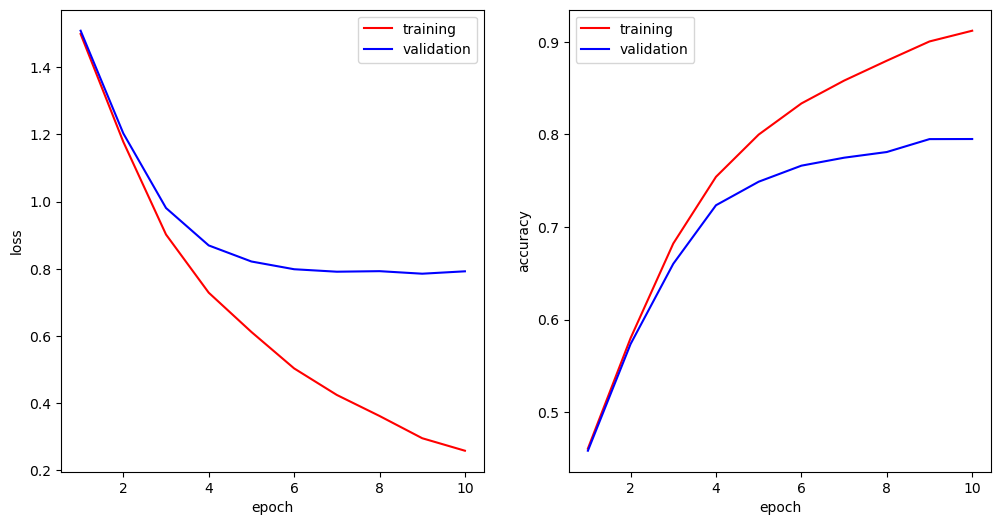

Fold #2
client 1 : 5000 samples
client 2 : 5001 samples
client 3 : 4998 samples
client 4 : 5001 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5000 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.2853, Accuracy = 0.5520
client 2 : Loss = 1.3160, Accuracy = 0.5300
client 3 : Loss = 1.3447, Accuracy = 0.5177
client 4 : Loss = 1.2827, Accuracy = 0.5505
client 5 : Loss = 1.3727, Accuracy = 0.5068
client 6 : Loss = 1.4925, Accuracy = 0.4637
client 7 : Loss = 1.3478, Accuracy = 0.5029
client 8 : Loss = 1.3972, Accuracy = 0.5027

Server :
    - training loss = 1.5730
    - training accuracy = 0.4418
    - validation loss = 1.5871
    - validation accuracy = 0.4382
        
>>> Round 2 ...
client 1 : Loss = 1.1020, Accuracy = 0.6041
client 2 : Loss = 1.0366, Accuracy = 0.6295
client 3 : Loss = 1.0025, Accuracy = 0.6487
client 4 : Loss = 0.9877, Accuracy = 0.6410
client 5 : Loss = 1.0277, Accuracy = 0.6391
client 6 : Loss = 1.0124, Accuracy = 0.6375
clie

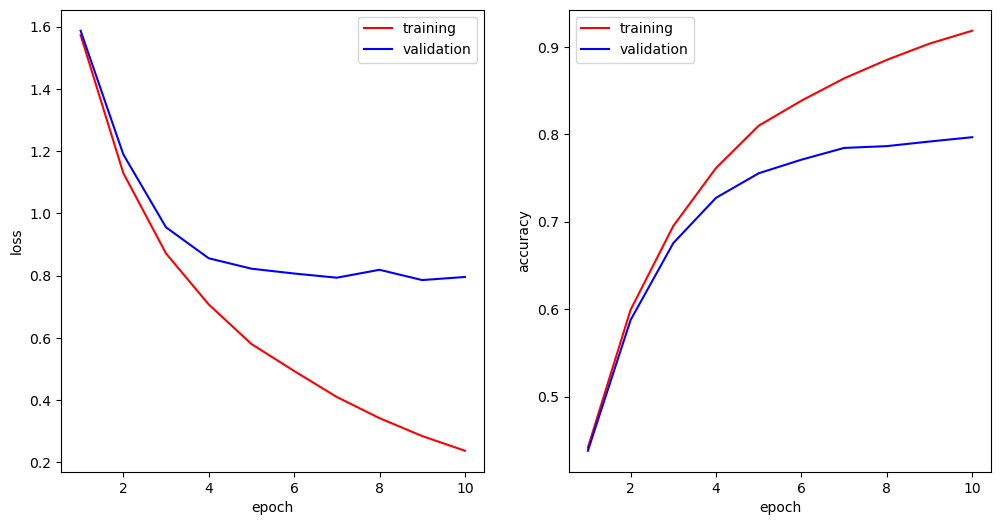

Fold #3
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 5003 samples
client 5 : 4997 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.3949, Accuracy = 0.5180
client 2 : Loss = 1.5194, Accuracy = 0.4820
client 3 : Loss = 1.2541, Accuracy = 0.5486
client 4 : Loss = 1.3032, Accuracy = 0.5403
client 5 : Loss = 1.6975, Accuracy = 0.4176
client 6 : Loss = 1.2746, Accuracy = 0.5496
client 7 : Loss = 1.4357, Accuracy = 0.4972
client 8 : Loss = 1.4175, Accuracy = 0.5049

Server :
    - training loss = 1.5494
    - training accuracy = 0.4537
    - validation loss = 1.5636
    - validation accuracy = 0.4487
        
>>> Round 2 ...
client 1 : Loss = 1.1460, Accuracy = 0.5859
client 2 : Loss = 1.1482, Accuracy = 0.5908
client 3 : Loss = 1.1248, Accuracy = 0.6068
client 4 : Loss = 0.9612, Accuracy = 0.6498
client 5 : Loss = 1.2153, Accuracy = 0.5721
client 6 : Loss = 1.0563, Accuracy = 0.6337
clie

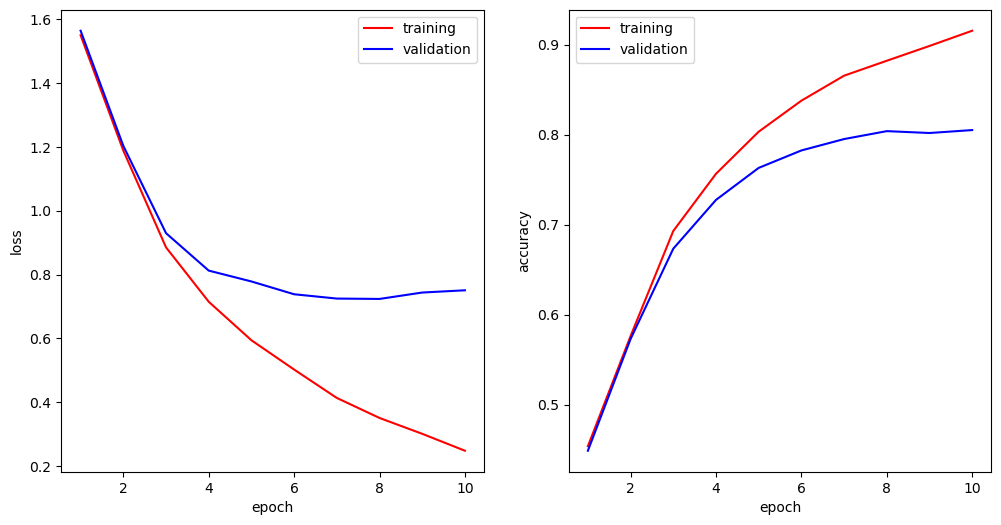

Fold #4
client 1 : 5001 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 5000 samples
client 5 : 4999 samples
client 6 : 5000 samples
client 7 : 4999 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.4346, Accuracy = 0.5013
client 2 : Loss = 1.5546, Accuracy = 0.4584
client 3 : Loss = 1.4859, Accuracy = 0.4664
client 4 : Loss = 1.5234, Accuracy = 0.4520
client 5 : Loss = 1.4218, Accuracy = 0.4947
client 6 : Loss = 1.4615, Accuracy = 0.4871
client 7 : Loss = 1.3323, Accuracy = 0.5116
client 8 : Loss = 1.4080, Accuracy = 0.5051

Server :
    - training loss = 1.5781
    - training accuracy = 0.4325
    - validation loss = 1.6032
    - validation accuracy = 0.4204
        
>>> Round 2 ...
client 1 : Loss = 0.9977, Accuracy = 0.6528
client 2 : Loss = 1.1693, Accuracy = 0.5807
client 3 : Loss = 1.0550, Accuracy = 0.6131
client 4 : Loss = 1.1272, Accuracy = 0.5938
client 5 : Loss = 1.1066, Accuracy = 0.6065
client 6 : Loss = 1.1224, Accuracy = 0.5910
clie

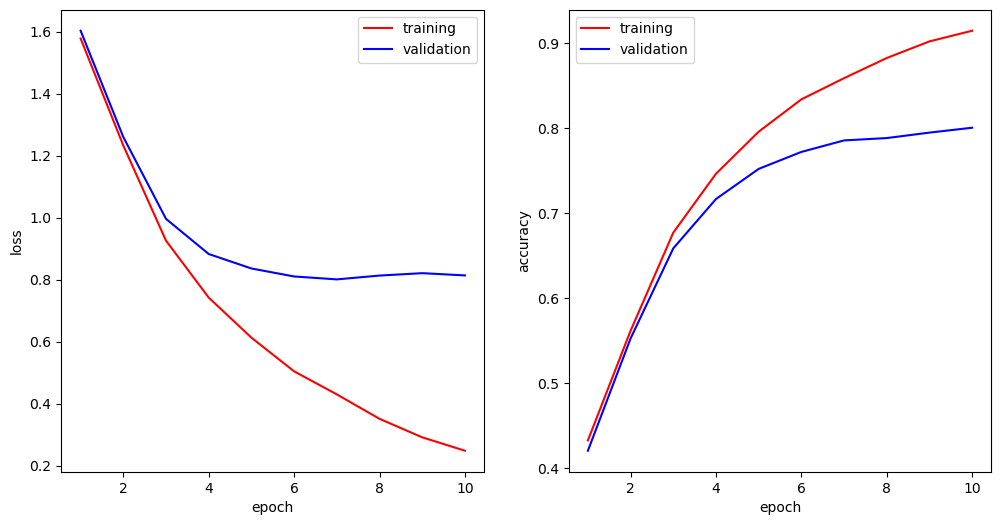

Fold #0
client 1 : 5000 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5000 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.0159, Accuracy = 0.6375
client 2 : Loss = 0.9998, Accuracy = 0.6372
client 3 : Loss = 1.1095, Accuracy = 0.6053
client 4 : Loss = 1.0156, Accuracy = 0.6537
client 5 : Loss = 1.0598, Accuracy = 0.6209
client 6 : Loss = 1.0490, Accuracy = 0.6281
client 7 : Loss = 1.0017, Accuracy = 0.6453
client 8 : Loss = 1.0234, Accuracy = 0.6351

Server :
    - training loss = 1.2802
    - training accuracy = 0.5559
    - validation loss = 1.3240
    - validation accuracy = 0.5387
        
>>> Round 2 ...
client 1 : Loss = 0.6447, Accuracy = 0.7836
client 2 : Loss = 0.5738, Accuracy = 0.8067
client 3 : Loss = 0.6937, Accuracy = 0.7616
client 4 : Loss = 0.6591, Accuracy = 0.7768
client 5 : Loss = 0.6080, Accuracy = 0.7998
client 6 : Loss = 0.5650, Accuracy = 0.8150
clie

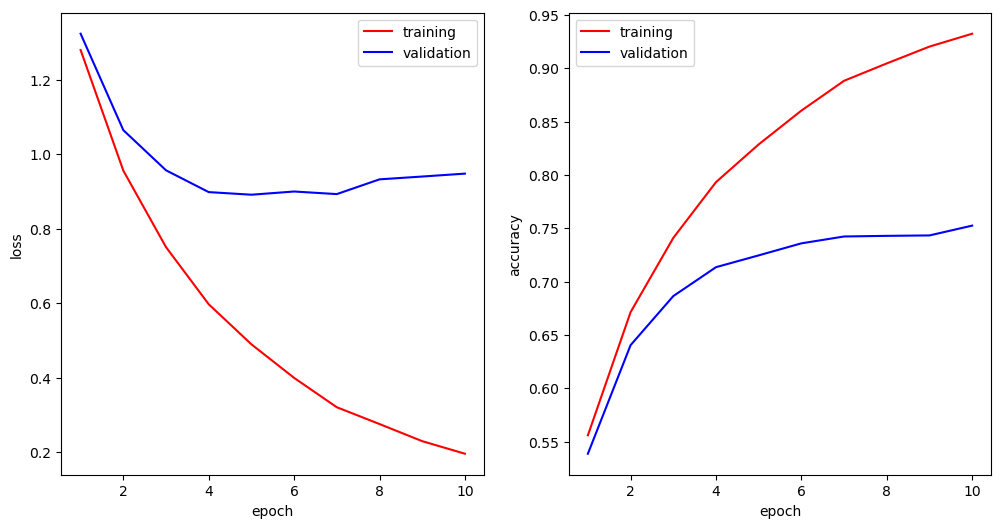

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5001 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 4998 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 0.9804, Accuracy = 0.6506
client 2 : Loss = 1.0832, Accuracy = 0.6149
client 3 : Loss = 1.0329, Accuracy = 0.6406
client 4 : Loss = 1.0137, Accuracy = 0.6391
client 5 : Loss = 1.0884, Accuracy = 0.6088
client 6 : Loss = 1.0377, Accuracy = 0.6315
client 7 : Loss = 1.1701, Accuracy = 0.5820
client 8 : Loss = 1.0057, Accuracy = 0.6466

Server :
    - training loss = 1.2850
    - training accuracy = 0.5506
    - validation loss = 1.3646
    - validation accuracy = 0.5328
        
>>> Round 2 ...
client 1 : Loss = 0.5515, Accuracy = 0.8176
client 2 : Loss = 0.7261, Accuracy = 0.7472
client 3 : Loss = 0.6454, Accuracy = 0.7797
client 4 : Loss = 0.6248, Accuracy = 0.7800
client 5 : Loss = 0.6630, Accuracy = 0.7676
client 6 : Loss = 0.7131, Accuracy = 0.7425
clie

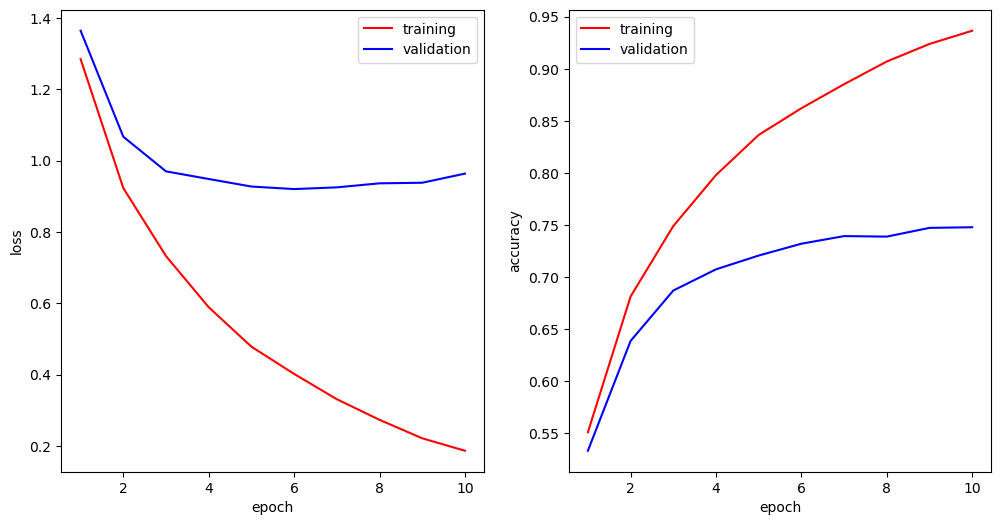

Fold #2
client 1 : 5000 samples
client 2 : 5001 samples
client 3 : 4998 samples
client 4 : 5001 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5000 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 0.9929, Accuracy = 0.6516
client 2 : Loss = 0.9188, Accuracy = 0.6723
client 3 : Loss = 1.0356, Accuracy = 0.6268
client 4 : Loss = 1.0092, Accuracy = 0.6433
client 5 : Loss = 1.0100, Accuracy = 0.6382
client 6 : Loss = 1.0100, Accuracy = 0.6303
client 7 : Loss = 1.0167, Accuracy = 0.6506
client 8 : Loss = 0.9819, Accuracy = 0.6578

Server :
    - training loss = 1.2571
    - training accuracy = 0.5669
    - validation loss = 1.3411
    - validation accuracy = 0.5404
        
>>> Round 2 ...
client 1 : Loss = 0.5015, Accuracy = 0.8340
client 2 : Loss = 0.5833, Accuracy = 0.7990
client 3 : Loss = 0.5803, Accuracy = 0.7946
client 4 : Loss = 0.5894, Accuracy = 0.7955
client 5 : Loss = 0.5724, Accuracy = 0.8032
client 6 : Loss = 0.5460, Accuracy = 0.8195
clie

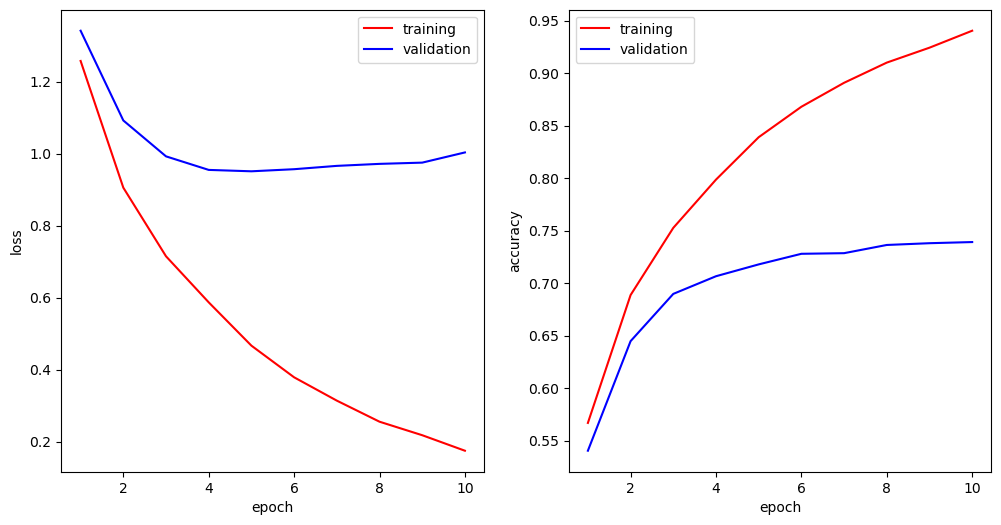

Fold #3
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 5003 samples
client 5 : 4997 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.0471, Accuracy = 0.6334
client 2 : Loss = 1.0648, Accuracy = 0.6225
client 3 : Loss = 1.0231, Accuracy = 0.6412
client 4 : Loss = 1.0687, Accuracy = 0.6194
client 5 : Loss = 1.1547, Accuracy = 0.5986
client 6 : Loss = 1.1114, Accuracy = 0.6042
client 7 : Loss = 1.0056, Accuracy = 0.6451
client 8 : Loss = 1.0556, Accuracy = 0.6232

Server :
    - training loss = 1.3167
    - training accuracy = 0.5451
    - validation loss = 1.3664
    - validation accuracy = 0.5245
        
>>> Round 2 ...
client 1 : Loss = 0.6505, Accuracy = 0.7738
client 2 : Loss = 0.5762, Accuracy = 0.8129
client 3 : Loss = 0.6714, Accuracy = 0.7705
client 4 : Loss = 0.5748, Accuracy = 0.8060
client 5 : Loss = 0.7849, Accuracy = 0.7130
client 6 : Loss = 0.6435, Accuracy = 0.7793
clie

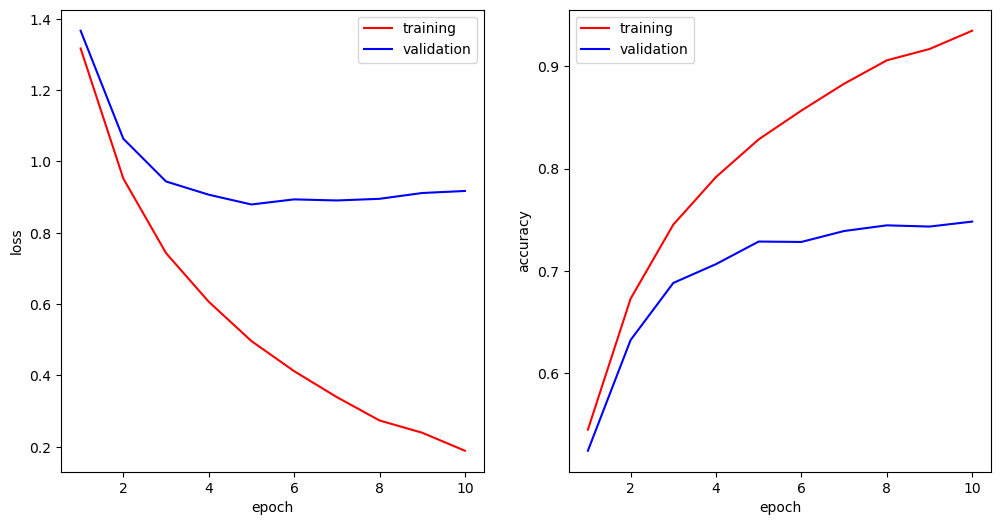

Fold #4
client 1 : 5001 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 5000 samples
client 5 : 4999 samples
client 6 : 5000 samples
client 7 : 4999 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 0.9823, Accuracy = 0.6436
client 2 : Loss = 1.0789, Accuracy = 0.6305
client 3 : Loss = 0.9538, Accuracy = 0.6635
client 4 : Loss = 0.9861, Accuracy = 0.6531
client 5 : Loss = 0.9502, Accuracy = 0.6621
client 6 : Loss = 0.9454, Accuracy = 0.6660
client 7 : Loss = 0.9908, Accuracy = 0.6410
client 8 : Loss = 1.0155, Accuracy = 0.6452

Server :
    - training loss = 1.2362
    - training accuracy = 0.5694
    - validation loss = 1.3047
    - validation accuracy = 0.5525
        
>>> Round 2 ...
client 1 : Loss = 0.5622, Accuracy = 0.8120
client 2 : Loss = 0.5808, Accuracy = 0.8006
client 3 : Loss = 0.6608, Accuracy = 0.7721
client 4 : Loss = 0.5418, Accuracy = 0.8166
client 5 : Loss = 0.5513, Accuracy = 0.8150
client 6 : Loss = 0.5552, Accuracy = 0.8170
clie

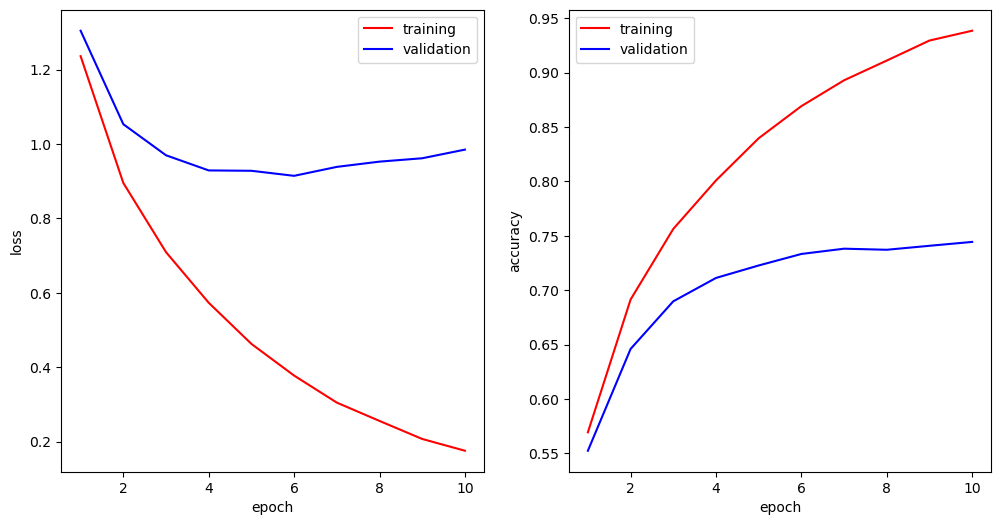

RESULTS
lr = 0.0100 : Accuracy = 0.7881131172180176
lr = 0.0050 : Accuracy = 0.7992286682128906
lr = 0.0010 : Accuracy = 0.7464003562927246

CPU times: user 2h 29min 18s, sys: 21.5 s, total: 2h 29min 40s
Wall time: 2h 30min 19s


In [17]:
%%time
n_splits = 5
rounds = 10
batch_size = 128
epochs = 5
lrs = [1e-2,5e-3,1e-3]#[1e-1,1e-2,1e-3,1e-4]
optimizer = optim.Adam

results = []
for lr in lrs:
    res = run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr)
    results.append((lr,res))
    
print("="*25)
print(f"RESULTS")
print("="*25)
for lr,res in results:
    print(f"lr = {lr:.4f} : Accuracy = {res}")
print()


### Summary: Best result achieved with lr = 0.005

## 3. Perform the cross validation for list of leraning rates on Non-IID dataset.

In [18]:
#Split the data in a non-iid way
proportions = generate_proportions(num_clients,num_classes, alpha=0.1)
proportions

[tensor([5.8258e-06, 1.3418e-02, 3.8577e-08, 9.2780e-01, 1.1994e-20, 5.0109e-07,
         5.8774e-02, 1.9820e-10]),
 tensor([7.1835e-02, 1.8115e-04, 1.2239e-02, 5.5099e-01, 1.2617e-29, 3.4115e-01,
         1.9799e-02, 3.8050e-03]),
 tensor([1.4787e-06, 8.3814e-01, 6.9813e-02, 8.8582e-07, 1.7929e-05, 8.2981e-03,
         8.2993e-02, 7.3801e-04]),
 tensor([5.3422e-08, 4.9903e-06, 3.6989e-02, 7.9815e-07, 8.4715e-03, 6.0040e-12,
         8.7382e-17, 9.5453e-01]),
 tensor([1.6736e-04, 1.6850e-13, 2.9363e-13, 5.5581e-01, 6.5501e-02, 1.0191e-01,
         2.3462e-02, 2.5316e-01]),
 tensor([1.2231e-19, 2.5063e-06, 2.1891e-07, 1.8516e-03, 1.4949e-01, 2.9673e-05,
         6.6019e-02, 7.8261e-01]),
 tensor([1.0577e-04, 4.8049e-06, 9.2850e-01, 1.1537e-04, 7.2822e-10, 7.0181e-02,
         1.0942e-03, 4.4152e-07]),
 tensor([6.9712e-07, 7.0154e-10, 5.9266e-03, 7.2205e-04, 4.1283e-04, 4.8942e-09,
         6.3553e-01, 3.5741e-01]),
 tensor([9.1626e-13, 9.6479e-02, 7.4254e-01, 1.3696e-01, 2.5235e-23, 9.8

Fold #0
client 1 : 6914 samples
client 2 : 4322 samples
client 3 : 2887 samples
client 4 : 8071 samples
client 5 : 2047 samples
client 6 : 1624 samples
client 7 : 4006 samples
client 8 : 10129 samples

>>> Round 1 ...
client 1 : Loss = 1.2103, Accuracy = 0.4798
client 2 : Loss = 0.5715, Accuracy = 0.7650
client 3 : Loss = 0.8836, Accuracy = 0.6856
client 4 : Loss = 1.0327, Accuracy = 0.4782
client 5 : Loss = 1.0392, Accuracy = 0.5188
client 6 : Loss = 0.4837, Accuracy = 0.8771
client 7 : Loss = 1.3795, Accuracy = 0.4968
client 8 : Loss = 1.1358, Accuracy = 0.3828

Server :
    - training loss = 2.3892
    - training accuracy = 0.0993
    - validation loss = 2.3873
    - validation accuracy = 0.1019
        
>>> Round 2 ...
client 1 : Loss = 1.2109, Accuracy = 0.4841
client 2 : Loss = 0.5630, Accuracy = 0.7645
client 3 : Loss = 0.8768, Accuracy = 0.6867
client 4 : Loss = 1.0315, Accuracy = 0.4854
client 5 : Loss = 1.0355, Accuracy = 0.5217
client 6 : Loss = 0.4839, Accuracy = 0.8757
cli

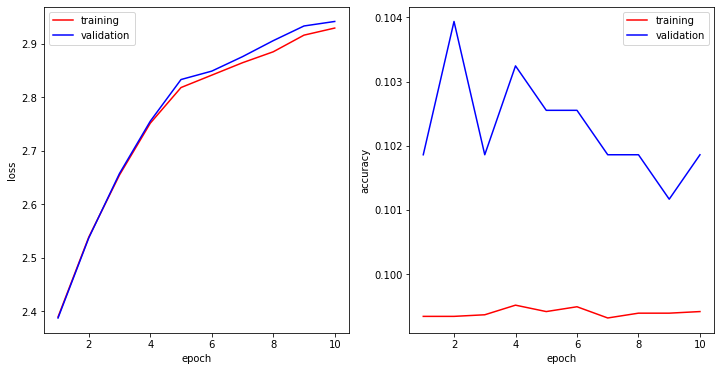

Fold #1
client 1 : 6882 samples
client 2 : 4378 samples
client 3 : 2843 samples
client 4 : 8089 samples
client 5 : 2054 samples
client 6 : 1642 samples
client 7 : 4005 samples
client 8 : 10107 samples

>>> Round 1 ...
client 1 : Loss = 0.9734, Accuracy = 0.6065
client 2 : Loss = 0.4802, Accuracy = 0.7927
client 3 : Loss = 0.6297, Accuracy = 0.7886
client 4 : Loss = 0.8702, Accuracy = 0.6484
client 5 : Loss = 0.6679, Accuracy = 0.7466
client 6 : Loss = 0.4027, Accuracy = 0.8766
client 7 : Loss = 0.9612, Accuracy = 0.6459
client 8 : Loss = 0.7289, Accuracy = 0.6426

Server :
    - training loss = 2.4195
    - training accuracy = 0.0996
    - validation loss = 2.4140
    - validation accuracy = 0.1008
        
>>> Round 2 ...
client 1 : Loss = 1.1532, Accuracy = 0.5013
client 2 : Loss = 0.3705, Accuracy = 0.8487
client 3 : Loss = 0.6008, Accuracy = 0.7981
client 4 : Loss = 1.0268, Accuracy = 0.4850
client 5 : Loss = 0.7792, Accuracy = 0.7057
client 6 : Loss = 0.3908, Accuracy = 0.8769
cli

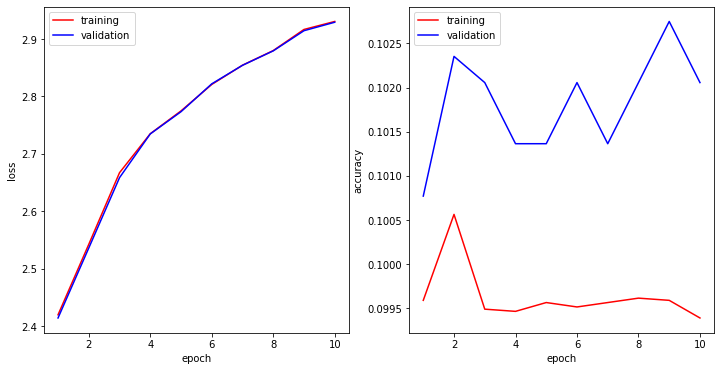

Fold #2
client 1 : 6886 samples
client 2 : 4304 samples
client 3 : 2854 samples
client 4 : 8071 samples
client 5 : 2057 samples
client 6 : 1632 samples
client 7 : 4034 samples
client 8 : 10162 samples

>>> Round 1 ...
client 1 : Loss = 1.2023, Accuracy = 0.4893
client 2 : Loss = 0.5685, Accuracy = 0.7619
client 3 : Loss = 0.8861, Accuracy = 0.6844
client 4 : Loss = 1.0306, Accuracy = 0.4873
client 5 : Loss = 1.0486, Accuracy = 0.5258
client 6 : Loss = 0.4877, Accuracy = 0.8780
client 7 : Loss = 1.3749, Accuracy = 0.5005
client 8 : Loss = 1.1360, Accuracy = 0.3855

Server :
    - training loss = 2.4200
    - training accuracy = 0.1002
    - validation loss = 2.4173
    - validation accuracy = 0.1008
        
>>> Round 2 ...
client 1 : Loss = 1.1942, Accuracy = 0.4934
client 2 : Loss = 0.5675, Accuracy = 0.7620
client 3 : Loss = 0.8811, Accuracy = 0.6828
client 4 : Loss = 1.0351, Accuracy = 0.4971
client 5 : Loss = 1.0422, Accuracy = 0.5211
client 6 : Loss = 0.4834, Accuracy = 0.8782
cli

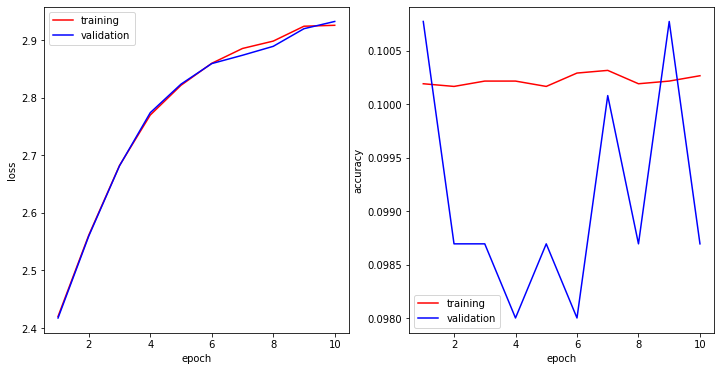

Fold #3
client 1 : 6882 samples
client 2 : 4328 samples
client 3 : 2824 samples
client 4 : 8095 samples
client 5 : 2058 samples
client 6 : 1636 samples
client 7 : 4032 samples
client 8 : 10145 samples

>>> Round 1 ...
client 1 : Loss = 0.9262, Accuracy = 0.6163
client 2 : Loss = 0.4875, Accuracy = 0.7891
client 3 : Loss = 0.6050, Accuracy = 0.8003
client 4 : Loss = 0.8255, Accuracy = 0.6493
client 5 : Loss = 0.7104, Accuracy = 0.7497
client 6 : Loss = 0.4407, Accuracy = 0.8760
client 7 : Loss = 1.0683, Accuracy = 0.6189
client 8 : Loss = 0.6998, Accuracy = 0.6623

Server :
    - training loss = 2.4893
    - training accuracy = 0.1003
    - validation loss = 2.4905
    - validation accuracy = 0.0991
        
>>> Round 2 ...
client 1 : Loss = 1.1975, Accuracy = 0.4954
client 2 : Loss = 0.4940, Accuracy = 0.7693
client 3 : Loss = 0.8932, Accuracy = 0.6807
client 4 : Loss = 1.0294, Accuracy = 0.4913
client 5 : Loss = 0.6708, Accuracy = 0.7402
client 6 : Loss = 0.4164, Accuracy = 0.8750
cli

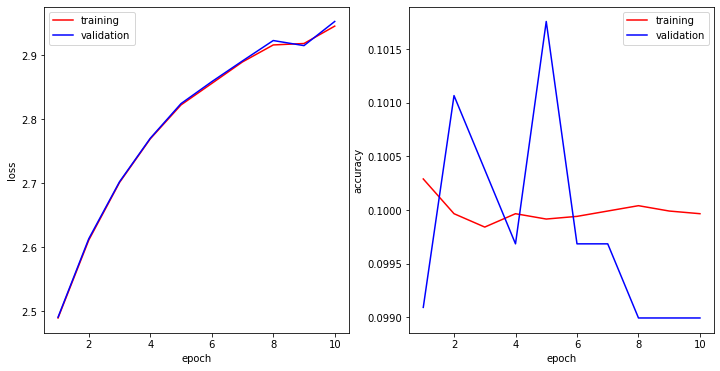

Fold #4
client 1 : 6839 samples
client 2 : 4301 samples
client 3 : 2843 samples
client 4 : 8164 samples
client 5 : 2042 samples
client 6 : 1635 samples
client 7 : 4024 samples
client 8 : 10152 samples

>>> Round 1 ...
client 1 : Loss = 1.0574, Accuracy = 0.5769
client 2 : Loss = 0.4619, Accuracy = 0.8060
client 3 : Loss = 0.6135, Accuracy = 0.7884
client 4 : Loss = 0.7500, Accuracy = 0.7058
client 5 : Loss = 0.6091, Accuracy = 0.7776
client 6 : Loss = 0.4029, Accuracy = 0.8793
client 7 : Loss = 1.0243, Accuracy = 0.6273
client 8 : Loss = 0.7108, Accuracy = 0.6546

Server :
    - training loss = 2.3794
    - training accuracy = 0.1008
    - validation loss = 2.3867
    - validation accuracy = 0.0956
        
>>> Round 2 ...
client 1 : Loss = 1.0528, Accuracy = 0.5785
client 2 : Loss = 0.4917, Accuracy = 0.7626
client 3 : Loss = 0.8042, Accuracy = 0.7286
client 4 : Loss = 0.9222, Accuracy = 0.6333
client 5 : Loss = 1.0344, Accuracy = 0.5248
client 6 : Loss = 0.3998, Accuracy = 0.8758
cli

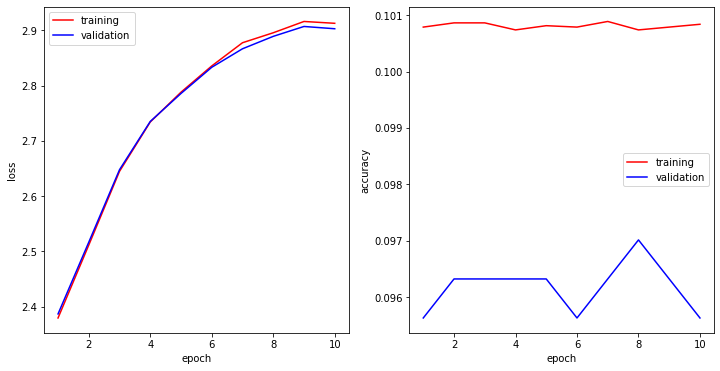

Fold #0
client 1 : 6914 samples
client 2 : 4322 samples
client 3 : 2887 samples
client 4 : 8071 samples
client 5 : 2047 samples
client 6 : 1624 samples
client 7 : 4006 samples
client 8 : 10129 samples

>>> Round 1 ...
client 1 : Loss = 0.7165, Accuracy = 0.7077
client 2 : Loss = 0.3815, Accuracy = 0.8587
client 3 : Loss = 0.6006, Accuracy = 0.8037
client 4 : Loss = 0.5987, Accuracy = 0.7878
client 5 : Loss = 0.3846, Accuracy = 0.8686
client 6 : Loss = 0.3793, Accuracy = 0.8922
client 7 : Loss = 0.7400, Accuracy = 0.7291
client 8 : Loss = 0.5760, Accuracy = 0.7504

Server :
    - training loss = 3.3525
    - training accuracy = 0.2039
    - validation loss = 3.3406
    - validation accuracy = 0.2104
        
>>> Round 2 ...
client 1 : Loss = 0.6649, Accuracy = 0.7332
client 2 : Loss = 0.2422, Accuracy = 0.9030
client 3 : Loss = 0.4647, Accuracy = 0.8336
client 4 : Loss = 0.3683, Accuracy = 0.8680
client 5 : Loss = 0.2093, Accuracy = 0.9262
client 6 : Loss = 0.2944, Accuracy = 0.9061
cli

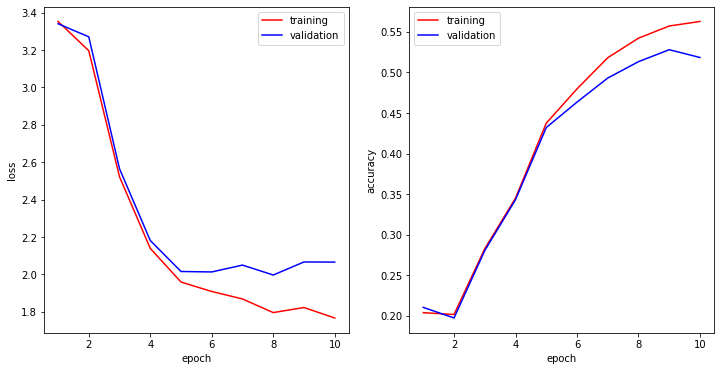

Fold #1
client 1 : 6882 samples
client 2 : 4378 samples
client 3 : 2843 samples
client 4 : 8089 samples
client 5 : 2054 samples
client 6 : 1642 samples
client 7 : 4005 samples
client 8 : 10107 samples

>>> Round 1 ...
client 1 : Loss = 0.6590, Accuracy = 0.7482
client 2 : Loss = 0.3318, Accuracy = 0.8628
client 3 : Loss = 0.5635, Accuracy = 0.8173
client 4 : Loss = 0.4057, Accuracy = 0.8520
client 5 : Loss = 0.4247, Accuracy = 0.8493
client 6 : Loss = 0.3576, Accuracy = 0.8860
client 7 : Loss = 0.7026, Accuracy = 0.7456
client 8 : Loss = 0.5467, Accuracy = 0.7681

Server :
    - training loss = 2.9930
    - training accuracy = 0.1546
    - validation loss = 3.0084
    - validation accuracy = 0.1527
        
>>> Round 2 ...
client 1 : Loss = 0.5546, Accuracy = 0.7804
client 2 : Loss = 0.2890, Accuracy = 0.8854
client 3 : Loss = 0.4275, Accuracy = 0.8467
client 4 : Loss = 0.3040, Accuracy = 0.8871
client 5 : Loss = 0.2984, Accuracy = 0.8951
client 6 : Loss = 0.2800, Accuracy = 0.9059
cli

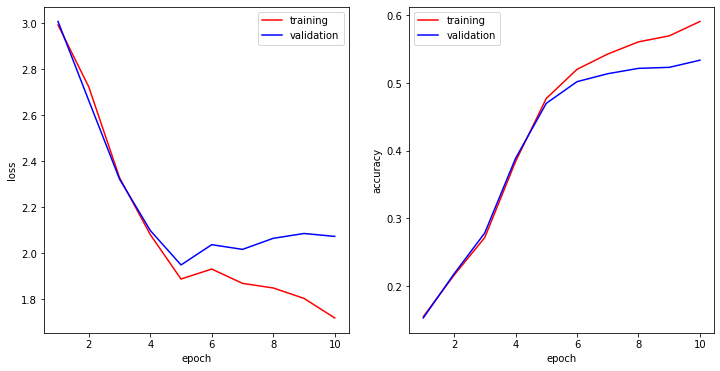

Fold #2
client 1 : 6886 samples
client 2 : 4304 samples
client 3 : 2854 samples
client 4 : 8071 samples
client 5 : 2057 samples
client 6 : 1632 samples
client 7 : 4034 samples
client 8 : 10162 samples

>>> Round 1 ...
client 1 : Loss = 0.6237, Accuracy = 0.7592
client 2 : Loss = 0.3071, Accuracy = 0.8779
client 3 : Loss = 0.5353, Accuracy = 0.8166
client 4 : Loss = 0.5930, Accuracy = 0.7850
client 5 : Loss = 0.5136, Accuracy = 0.8090
client 6 : Loss = 0.3210, Accuracy = 0.8938
client 7 : Loss = 0.6464, Accuracy = 0.7685
client 8 : Loss = 0.5343, Accuracy = 0.7646

Server :
    - training loss = 3.4422
    - training accuracy = 0.1461
    - validation loss = 3.4683
    - validation accuracy = 0.1477
        
>>> Round 2 ...
client 1 : Loss = 0.5337, Accuracy = 0.7974
client 2 : Loss = 0.2536, Accuracy = 0.9022
client 3 : Loss = 0.4415, Accuracy = 0.8432
client 4 : Loss = 0.3476, Accuracy = 0.8744
client 5 : Loss = 0.2957, Accuracy = 0.8951
client 6 : Loss = 0.2744, Accuracy = 0.9038
cli

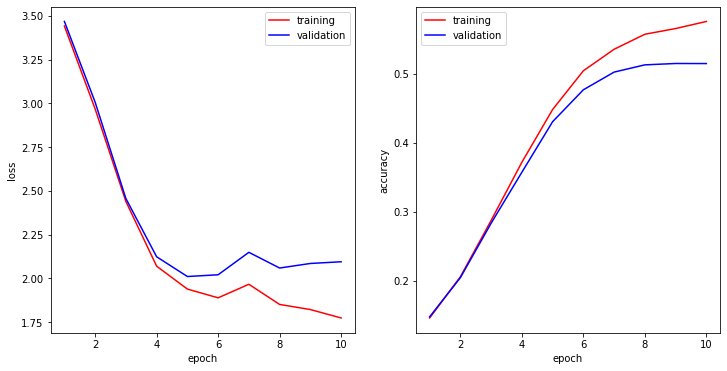

Fold #3
client 1 : 6882 samples
client 2 : 4328 samples
client 3 : 2824 samples
client 4 : 8095 samples
client 5 : 2058 samples
client 6 : 1636 samples
client 7 : 4032 samples
client 8 : 10145 samples

>>> Round 1 ...
client 1 : Loss = 0.6141, Accuracy = 0.7598
client 2 : Loss = 0.3849, Accuracy = 0.8514
client 3 : Loss = 0.6897, Accuracy = 0.7609
client 4 : Loss = 0.4189, Accuracy = 0.8444
client 5 : Loss = 0.4221, Accuracy = 0.8637
client 6 : Loss = 0.3236, Accuracy = 0.8993
client 7 : Loss = 0.6922, Accuracy = 0.7466
client 8 : Loss = 0.5623, Accuracy = 0.7551

Server :
    - training loss = 3.1632
    - training accuracy = 0.1641
    - validation loss = 3.1613
    - validation accuracy = 0.1675
        
>>> Round 2 ...
client 1 : Loss = 0.5317, Accuracy = 0.7973
client 2 : Loss = 0.2863, Accuracy = 0.8878
client 3 : Loss = 0.4198, Accuracy = 0.8488
client 4 : Loss = 0.3103, Accuracy = 0.8876
client 5 : Loss = 0.2827, Accuracy = 0.9151
client 6 : Loss = 0.2326, Accuracy = 0.9169
cli

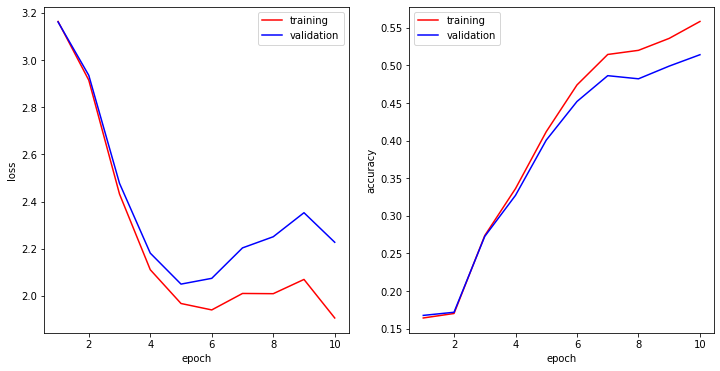

Fold #4
client 1 : 6839 samples
client 2 : 4301 samples
client 3 : 2843 samples
client 4 : 8164 samples
client 5 : 2042 samples
client 6 : 1635 samples
client 7 : 4024 samples
client 8 : 10152 samples

>>> Round 1 ...
client 1 : Loss = 0.6462, Accuracy = 0.7476
client 2 : Loss = 0.2978, Accuracy = 0.8782
client 3 : Loss = 0.5841, Accuracy = 0.8059
client 4 : Loss = 0.4302, Accuracy = 0.8394
client 5 : Loss = 0.3723, Accuracy = 0.8766
client 6 : Loss = 0.4190, Accuracy = 0.8785
client 7 : Loss = 0.6599, Accuracy = 0.7620
client 8 : Loss = 0.5514, Accuracy = 0.7589

Server :
    - training loss = 2.9533
    - training accuracy = 0.1780
    - validation loss = 2.9373
    - validation accuracy = 0.1740
        
>>> Round 2 ...
client 1 : Loss = 0.5722, Accuracy = 0.7784
client 2 : Loss = 0.2687, Accuracy = 0.8869
client 3 : Loss = 0.4133, Accuracy = 0.8489
client 4 : Loss = 0.3125, Accuracy = 0.8848
client 5 : Loss = 0.2591, Accuracy = 0.9123
client 6 : Loss = 0.2811, Accuracy = 0.9001
cli

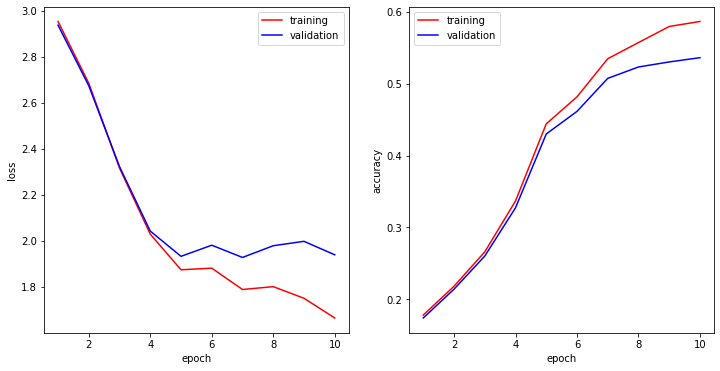

Fold #0
client 1 : 6914 samples
client 2 : 4322 samples
client 3 : 2887 samples
client 4 : 8071 samples
client 5 : 2047 samples
client 6 : 1624 samples
client 7 : 4006 samples
client 8 : 10129 samples

>>> Round 1 ...
client 1 : Loss = 0.5449, Accuracy = 0.8013
client 2 : Loss = 0.1393, Accuracy = 0.9450
client 3 : Loss = 0.1812, Accuracy = 0.9329
client 4 : Loss = 0.2641, Accuracy = 0.9016
client 5 : Loss = 0.1258, Accuracy = 0.9541
client 6 : Loss = 0.0668, Accuracy = 0.9796
client 7 : Loss = 0.3582, Accuracy = 0.8769
client 8 : Loss = 0.4428, Accuracy = 0.8075

Server :
    - training loss = 2.0615
    - training accuracy = 0.3042
    - validation loss = 2.1204
    - validation accuracy = 0.2954
        
>>> Round 2 ...
client 1 : Loss = 0.5459, Accuracy = 0.7928
client 2 : Loss = 0.0785, Accuracy = 0.9711
client 3 : Loss = 0.1068, Accuracy = 0.9649
client 4 : Loss = 0.1730, Accuracy = 0.9381
client 5 : Loss = 0.0500, Accuracy = 0.9858
client 6 : Loss = 0.0638, Accuracy = 0.9766
cli

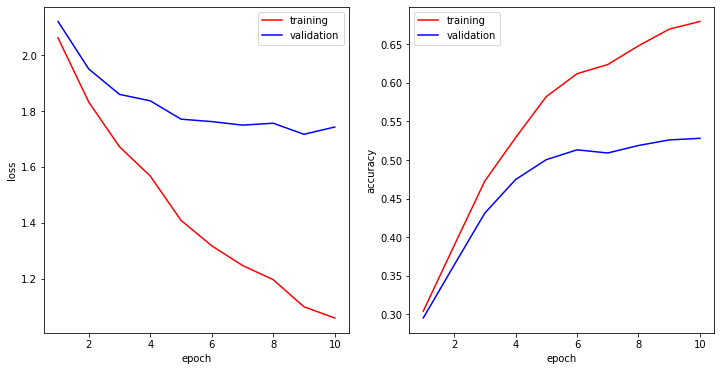

Fold #1
client 1 : 6882 samples
client 2 : 4378 samples
client 3 : 2843 samples
client 4 : 8089 samples
client 5 : 2054 samples
client 6 : 1642 samples
client 7 : 4005 samples
client 8 : 10107 samples

>>> Round 1 ...
client 1 : Loss = 0.3462, Accuracy = 0.8736
client 2 : Loss = 0.1462, Accuracy = 0.9471
client 3 : Loss = 0.2477, Accuracy = 0.9092
client 4 : Loss = 0.2223, Accuracy = 0.9189
client 5 : Loss = 0.1959, Accuracy = 0.9308
client 6 : Loss = 0.1073, Accuracy = 0.9648
client 7 : Loss = 0.3235, Accuracy = 0.8893
client 8 : Loss = 0.3909, Accuracy = 0.8359

Server :
    - training loss = 2.1334
    - training accuracy = 0.3003
    - validation loss = 2.1767
    - validation accuracy = 0.2944
        
>>> Round 2 ...
client 1 : Loss = 0.1819, Accuracy = 0.9360
client 2 : Loss = 0.0625, Accuracy = 0.9801
client 3 : Loss = 0.1037, Accuracy = 0.9688
client 4 : Loss = 0.1180, Accuracy = 0.9588
client 5 : Loss = 0.1730, Accuracy = 0.9418
client 6 : Loss = 0.0381, Accuracy = 0.9889
cli

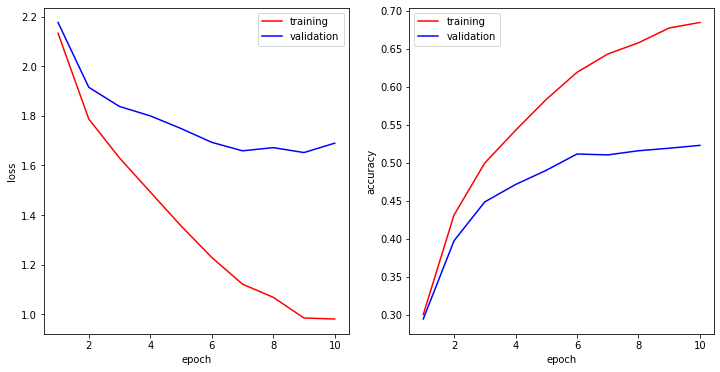

Fold #2
client 1 : 6886 samples
client 2 : 4304 samples
client 3 : 2854 samples
client 4 : 8071 samples
client 5 : 2057 samples
client 6 : 1632 samples
client 7 : 4034 samples
client 8 : 10162 samples

>>> Round 1 ...
client 1 : Loss = 0.3550, Accuracy = 0.8663
client 2 : Loss = 0.1120, Accuracy = 0.9573
client 3 : Loss = 0.1890, Accuracy = 0.9294
client 4 : Loss = 0.2075, Accuracy = 0.9220
client 5 : Loss = 0.1643, Accuracy = 0.9458
client 6 : Loss = 0.0731, Accuracy = 0.9806
client 7 : Loss = 0.3099, Accuracy = 0.8936
client 8 : Loss = 0.4048, Accuracy = 0.8310

Server :
    - training loss = 1.9527
    - training accuracy = 0.3194
    - validation loss = 2.0132
    - validation accuracy = 0.3029
        
>>> Round 2 ...
client 1 : Loss = 0.1925, Accuracy = 0.9347
client 2 : Loss = 0.0685, Accuracy = 0.9776
client 3 : Loss = 0.1030, Accuracy = 0.9671
client 4 : Loss = 0.1997, Accuracy = 0.9263
client 5 : Loss = 0.1125, Accuracy = 0.9595
client 6 : Loss = 0.0342, Accuracy = 0.9928
cli

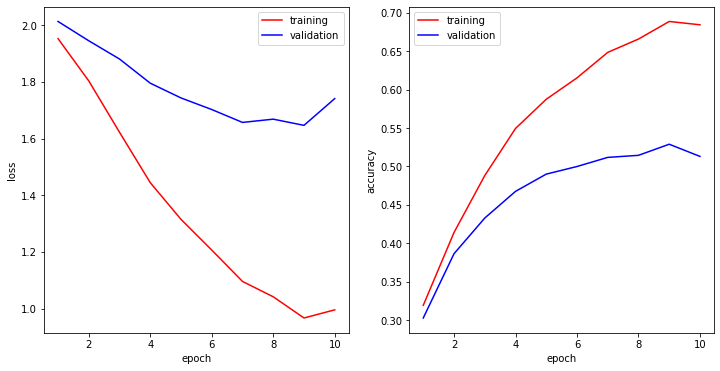

Fold #3
client 1 : 6882 samples
client 2 : 4328 samples
client 3 : 2824 samples
client 4 : 8095 samples
client 5 : 2058 samples
client 6 : 1636 samples
client 7 : 4032 samples
client 8 : 10145 samples

>>> Round 1 ...
client 1 : Loss = 0.3562, Accuracy = 0.8676
client 2 : Loss = 0.1216, Accuracy = 0.9513
client 3 : Loss = 0.3315, Accuracy = 0.8804
client 4 : Loss = 0.2299, Accuracy = 0.9167
client 5 : Loss = 0.1210, Accuracy = 0.9573
client 6 : Loss = 0.0897, Accuracy = 0.9700
client 7 : Loss = 0.3152, Accuracy = 0.8894
client 8 : Loss = 0.4325, Accuracy = 0.8149

Server :
    - training loss = 2.0674
    - training accuracy = 0.3113
    - validation loss = 2.1235
    - validation accuracy = 0.2990
        
>>> Round 2 ...
client 1 : Loss = 0.2082, Accuracy = 0.9259
client 2 : Loss = 0.0610, Accuracy = 0.9809
client 3 : Loss = 0.1725, Accuracy = 0.9416
client 4 : Loss = 0.1288, Accuracy = 0.9559
client 5 : Loss = 0.0839, Accuracy = 0.9670
client 6 : Loss = 0.0452, Accuracy = 0.9834
cli

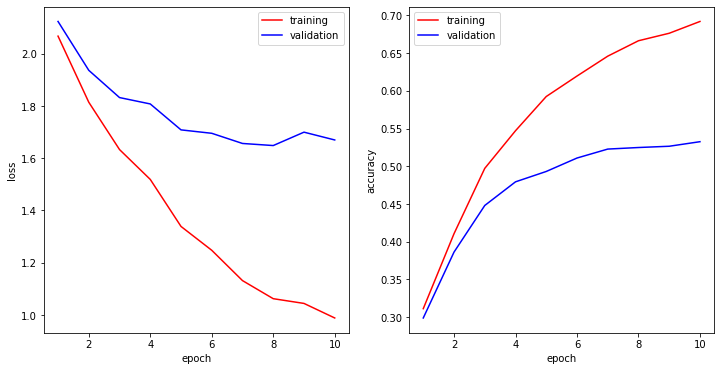

Fold #4
client 1 : 6839 samples
client 2 : 4301 samples
client 3 : 2843 samples
client 4 : 8164 samples
client 5 : 2042 samples
client 6 : 1635 samples
client 7 : 4024 samples
client 8 : 10152 samples

>>> Round 1 ...
client 1 : Loss = 0.3782, Accuracy = 0.8551
client 2 : Loss = 0.1334, Accuracy = 0.9481
client 3 : Loss = 0.2390, Accuracy = 0.9166
client 4 : Loss = 0.2325, Accuracy = 0.9117
client 5 : Loss = 0.0962, Accuracy = 0.9687
client 6 : Loss = 0.0868, Accuracy = 0.9712
client 7 : Loss = 0.2889, Accuracy = 0.8939
client 8 : Loss = 0.4198, Accuracy = 0.8216

Server :
    - training loss = 1.9954
    - training accuracy = 0.3097
    - validation loss = 2.0545
    - validation accuracy = 0.2944
        
>>> Round 2 ...
client 1 : Loss = 0.2247, Accuracy = 0.9204
client 2 : Loss = 0.0698, Accuracy = 0.9764
client 3 : Loss = 0.1069, Accuracy = 0.9631
client 4 : Loss = 0.1101, Accuracy = 0.9608
client 5 : Loss = 0.0397, Accuracy = 0.9897
client 6 : Loss = 0.0475, Accuracy = 0.9872
cli

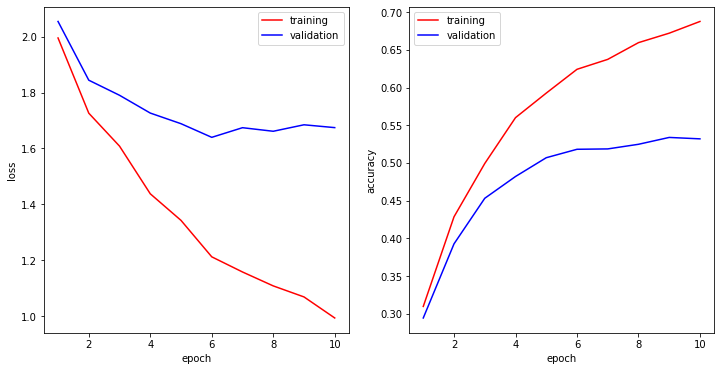

Fold #0
client 1 : 6914 samples
client 2 : 4322 samples
client 3 : 2887 samples
client 4 : 8071 samples
client 5 : 2047 samples
client 6 : 1624 samples
client 7 : 4006 samples
client 8 : 10129 samples

>>> Round 1 ...
client 1 : Loss = 0.6640, Accuracy = 0.7467
client 2 : Loss = 0.2200, Accuracy = 0.9224
client 3 : Loss = 0.3739, Accuracy = 0.8845
client 4 : Loss = 0.4633, Accuracy = 0.8300
client 5 : Loss = 0.2865, Accuracy = 0.9150
client 6 : Loss = 0.3536, Accuracy = 0.9134
client 7 : Loss = 0.5667, Accuracy = 0.8041
client 8 : Loss = 0.5260, Accuracy = 0.7816

Server :
    - training loss = 1.9833
    - training accuracy = 0.2901
    - validation loss = 2.0350
    - validation accuracy = 0.2753
        
>>> Round 2 ...
client 1 : Loss = 0.5758, Accuracy = 0.7783
client 2 : Loss = 0.2045, Accuracy = 0.9271
client 3 : Loss = 0.3397, Accuracy = 0.8976
client 4 : Loss = 0.3695, Accuracy = 0.8650
client 5 : Loss = 0.2449, Accuracy = 0.9311
client 6 : Loss = 0.2799, Accuracy = 0.9318
cli

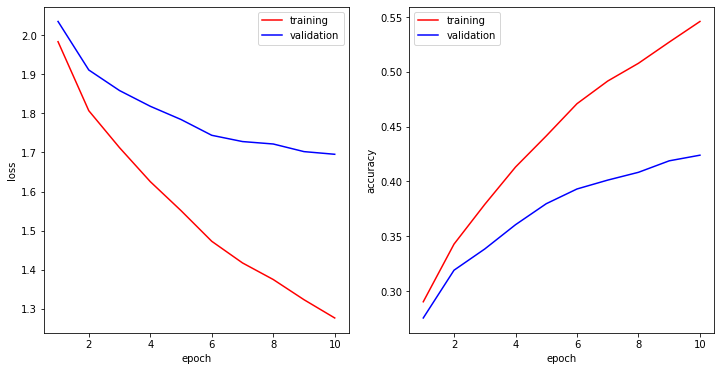

Fold #1
client 1 : 6882 samples
client 2 : 4378 samples
client 3 : 2843 samples
client 4 : 8089 samples
client 5 : 2054 samples
client 6 : 1642 samples
client 7 : 4005 samples
client 8 : 10107 samples

>>> Round 1 ...
client 1 : Loss = 0.5614, Accuracy = 0.7882
client 2 : Loss = 0.2193, Accuracy = 0.9196
client 3 : Loss = 0.4093, Accuracy = 0.8718
client 4 : Loss = 0.4361, Accuracy = 0.8409
client 5 : Loss = 0.3791, Accuracy = 0.8909
client 6 : Loss = 0.3107, Accuracy = 0.9271
client 7 : Loss = 0.5969, Accuracy = 0.7962
client 8 : Loss = 0.4926, Accuracy = 0.8000

Server :
    - training loss = 1.9932
    - training accuracy = 0.2832
    - validation loss = 2.0543
    - validation accuracy = 0.2579
        
>>> Round 2 ...
client 1 : Loss = 0.4762, Accuracy = 0.8254
client 2 : Loss = 0.2080, Accuracy = 0.9261
client 3 : Loss = 0.3564, Accuracy = 0.8862
client 4 : Loss = 0.3401, Accuracy = 0.8743
client 5 : Loss = 0.2679, Accuracy = 0.9311
client 6 : Loss = 0.2667, Accuracy = 0.9292
cli

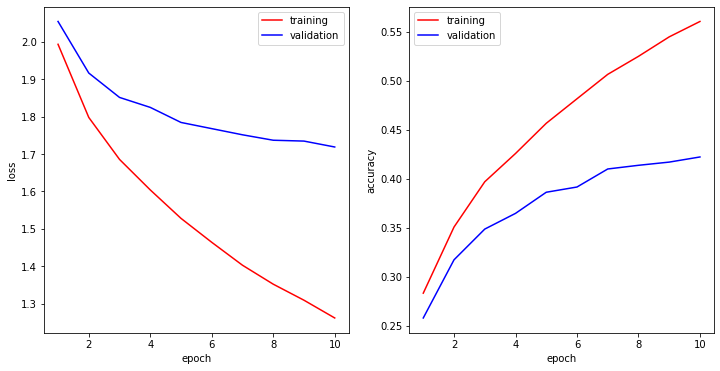

Fold #2
client 1 : 6886 samples
client 2 : 4304 samples
client 3 : 2854 samples
client 4 : 8071 samples
client 5 : 2057 samples
client 6 : 1632 samples
client 7 : 4034 samples
client 8 : 10162 samples

>>> Round 1 ...
client 1 : Loss = 2.0399, Accuracy = 0.4894
client 2 : Loss = 2.1335, Accuracy = 0.7630
client 3 : Loss = 2.2136, Accuracy = 0.6844
client 4 : Loss = 1.9002, Accuracy = 0.4892
client 5 : Loss = 2.2493, Accuracy = 0.5183
client 6 : Loss = 2.2519, Accuracy = 0.8772
client 7 : Loss = 2.2127, Accuracy = 0.5014
client 8 : Loss = 1.6790, Accuracy = 0.3391

Server :
    - training loss = 2.3040
    - training accuracy = 0.1002
    - validation loss = 2.3045
    - validation accuracy = 0.0980
        
>>> Round 2 ...
client 1 : Loss = 1.5119, Accuracy = 0.4933
client 2 : Loss = 1.6894, Accuracy = 0.7622
client 3 : Loss = 1.9609, Accuracy = 0.4923
client 4 : Loss = 1.2793, Accuracy = 0.4993
client 5 : Loss = 2.1168, Accuracy = 0.5379
client 6 : Loss = 2.1554, Accuracy = 0.8676
cli

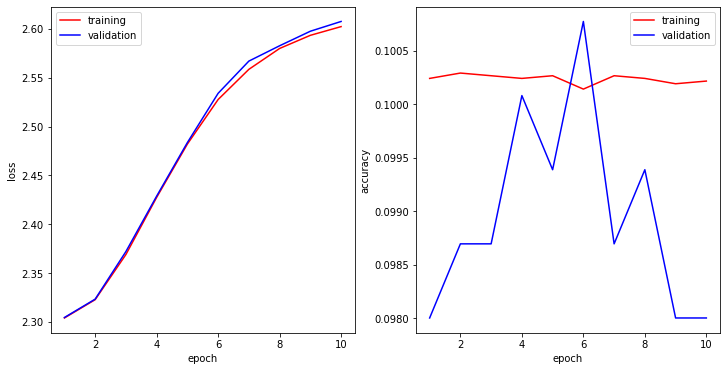

Fold #3
client 1 : 6882 samples
client 2 : 4328 samples
client 3 : 2824 samples
client 4 : 8095 samples
client 5 : 2058 samples
client 6 : 1636 samples
client 7 : 4032 samples
client 8 : 10145 samples

>>> Round 1 ...
client 1 : Loss = 2.0496, Accuracy = 0.4574
client 2 : Loss = 2.1483, Accuracy = 0.7628
client 3 : Loss = 2.2151, Accuracy = 0.6912
client 4 : Loss = 1.7619, Accuracy = 0.4420
client 5 : Loss = 2.2588, Accuracy = 0.5221
client 6 : Loss = 2.2548, Accuracy = 0.8793
client 7 : Loss = 2.2182, Accuracy = 0.4973
client 8 : Loss = 1.6709, Accuracy = 0.3874

Server :
    - training loss = 2.3050
    - training accuracy = 0.0999
    - validation loss = 2.3048
    - validation accuracy = 0.1011
        
>>> Round 2 ...
client 1 : Loss = 1.5563, Accuracy = 0.4942
client 2 : Loss = 1.7618, Accuracy = 0.7629
client 3 : Loss = 1.9519, Accuracy = 0.5044
client 4 : Loss = 1.2209, Accuracy = 0.4917
client 5 : Loss = 2.1566, Accuracy = 0.5176
client 6 : Loss = 2.1513, Accuracy = 0.8569
cli

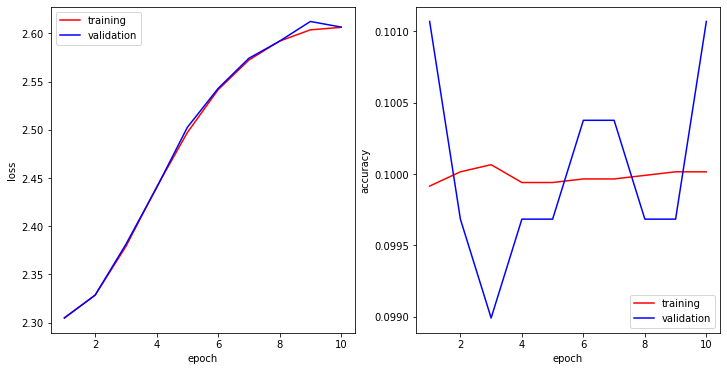

Fold #4
client 1 : 6839 samples
client 2 : 4301 samples
client 3 : 2843 samples
client 4 : 8164 samples
client 5 : 2042 samples
client 6 : 1635 samples
client 7 : 4024 samples
client 8 : 10152 samples

>>> Round 1 ...
client 1 : Loss = 0.5733, Accuracy = 0.7777
client 2 : Loss = 0.2263, Accuracy = 0.9210
client 3 : Loss = 0.3816, Accuracy = 0.8744
client 4 : Loss = 0.4139, Accuracy = 0.8448
client 5 : Loss = 0.2824, Accuracy = 0.9135
client 6 : Loss = 0.4260, Accuracy = 0.9003
client 7 : Loss = 0.5838, Accuracy = 0.7970
client 8 : Loss = 0.4959, Accuracy = 0.7965

Server :
    - training loss = 1.9547
    - training accuracy = 0.2992
    - validation loss = 2.0330
    - validation accuracy = 0.2678
        
>>> Round 2 ...
client 1 : Loss = 0.4887, Accuracy = 0.8160
client 2 : Loss = 0.2053, Accuracy = 0.9298
client 3 : Loss = 0.3142, Accuracy = 0.9005
client 4 : Loss = 0.3147, Accuracy = 0.8875
client 5 : Loss = 0.2694, Accuracy = 0.9212
client 6 : Loss = 0.2950, Accuracy = 0.9310
cli

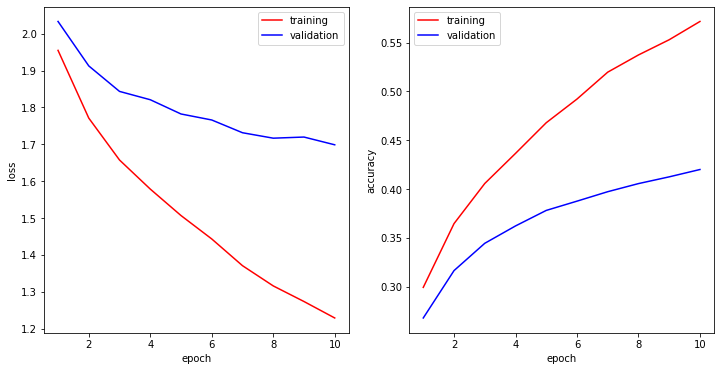

RESULTS
lr = 0.1000 : Accuracy = 0.09944620728492737
lr = 0.0100 : Accuracy = 0.5234177112579346
lr = 0.0010 : Accuracy = 0.5257120132446289
lr = 0.0001 : Accuracy = 0.2930379807949066

CPU times: user 1h 27min 45s, sys: 18min 1s, total: 1h 45min 46s
Wall time: 6h 34min 26s


In [ ]:
%%time
n_splits = 5
rounds = 10
batch_size = 128
epochs = 5
lrs = [1e-1,1e-2,1e-3,1e-4]
optimizer = optim.Adam

results = []
for lr in lrs:
    res = run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr)
    results.append((lr,res))
    
print("="*25)
print(f"RESULTS")
print("="*25)
for lr,res in results:
    print(f"lr = {lr:.4f} : Accuracy = {res}")
print()


### Comment: It can be seen that best learning rates are 0.001 and 0.01. Let's try to check for value in between these values, 0.005:

Fold #0
client 1 : 2564 samples
client 2 : 3766 samples
client 3 : 7174 samples
client 4 : 8820 samples
client 5 : 899 samples
client 6 : 2104 samples
client 7 : 3564 samples
client 8 : 11109 samples

>>> Round 1 ...
client 1 : Loss = 0.4913, Accuracy = 0.8527
client 2 : Loss = 0.1858, Accuracy = 0.9363
client 3 : Loss = 0.5031, Accuracy = 0.8621
client 4 : Loss = 0.4690, Accuracy = 0.8324
client 5 : Loss = 0.7845, Accuracy = 0.6517
client 6 : Loss = 0.4993, Accuracy = 0.8031
client 7 : Loss = 0.6696, Accuracy = 0.7815
client 8 : Loss = 0.8082, Accuracy = 0.6845

Server :
    - training loss = 2.7085
    - training accuracy = 0.2466
    - validation loss = 2.7145
    - validation accuracy = 0.2396
        
>>> Round 2 ...
client 1 : Loss = 0.2712, Accuracy = 0.9059
client 2 : Loss = 0.1662, Accuracy = 0.9426
client 3 : Loss = 0.3535, Accuracy = 0.8955
client 4 : Loss = 0.3653, Accuracy = 0.8650
client 5 : Loss = 0.7235, Accuracy = 0.7669
client 6 : Loss = 0.3916, Accuracy = 0.8571
clie

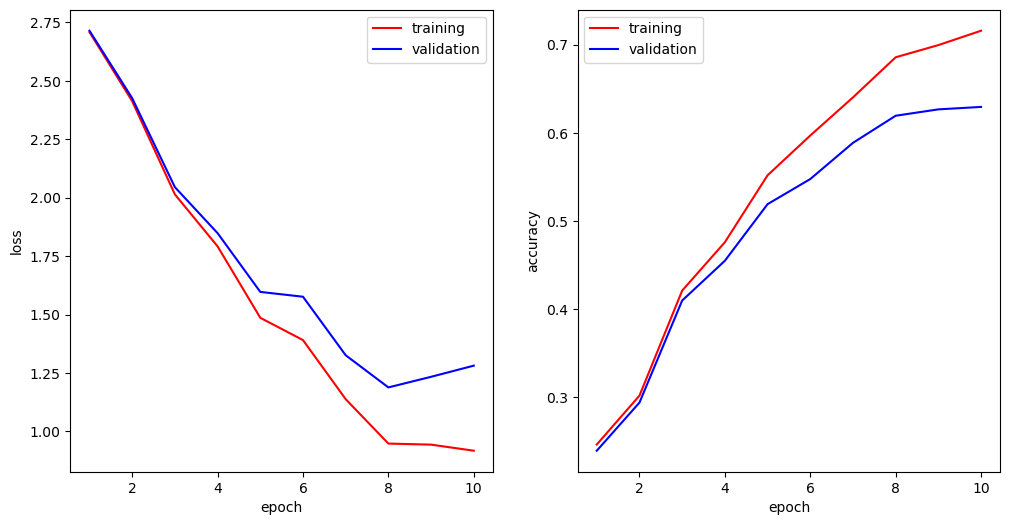

Fold #1
client 1 : 2584 samples
client 2 : 3808 samples
client 3 : 7217 samples
client 4 : 8740 samples
client 5 : 892 samples
client 6 : 2094 samples
client 7 : 3562 samples
client 8 : 11103 samples

>>> Round 1 ...
client 1 : Loss = 0.3311, Accuracy = 0.8821
client 2 : Loss = 0.2046, Accuracy = 0.9331
client 3 : Loss = 0.3669, Accuracy = 0.8951
client 4 : Loss = 0.4902, Accuracy = 0.8333
client 5 : Loss = 0.6474, Accuracy = 0.7199
client 6 : Loss = 0.4873, Accuracy = 0.7989
client 7 : Loss = 0.6993, Accuracy = 0.7695
client 8 : Loss = 0.8548, Accuracy = 0.6655

Server :
    - training loss = 2.8612
    - training accuracy = 0.2329
    - validation loss = 2.8667
    - validation accuracy = 0.2379
        
>>> Round 2 ...
client 1 : Loss = 0.2435, Accuracy = 0.8924
client 2 : Loss = 0.1861, Accuracy = 0.9380
client 3 : Loss = 0.3213, Accuracy = 0.9013
client 4 : Loss = 0.3698, Accuracy = 0.8690
client 5 : Loss = 0.4060, Accuracy = 0.8272
client 6 : Loss = 0.3556, Accuracy = 0.8634
clie

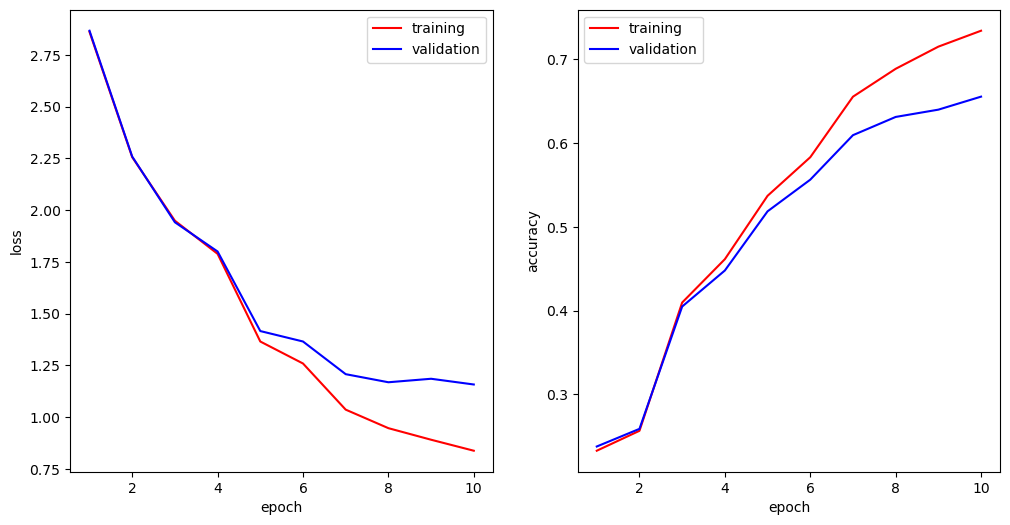

Fold #2
client 1 : 2585 samples
client 2 : 3791 samples
client 3 : 7182 samples
client 4 : 8745 samples
client 5 : 898 samples
client 6 : 2073 samples
client 7 : 3568 samples
client 8 : 11158 samples

>>> Round 1 ...
client 1 : Loss = 0.2591, Accuracy = 0.8977
client 2 : Loss = 0.2182, Accuracy = 0.9243
client 3 : Loss = 0.3804, Accuracy = 0.8848
client 4 : Loss = 0.5486, Accuracy = 0.8080
client 5 : Loss = 1.1479, Accuracy = 0.6318
client 6 : Loss = 0.4762, Accuracy = 0.8273
client 7 : Loss = 0.6778, Accuracy = 0.7746
client 8 : Loss = 0.8770, Accuracy = 0.6532

Server :
    - training loss = 2.5948
    - training accuracy = 0.2386
    - validation loss = 2.5691
    - validation accuracy = 0.2355
        
>>> Round 2 ...
client 1 : Loss = 0.2244, Accuracy = 0.9035
client 2 : Loss = 0.1849, Accuracy = 0.9372
client 3 : Loss = 0.3515, Accuracy = 0.8939
client 4 : Loss = 0.3802, Accuracy = 0.8635
client 5 : Loss = 0.5691, Accuracy = 0.7617
client 6 : Loss = 0.3766, Accuracy = 0.8758
clie

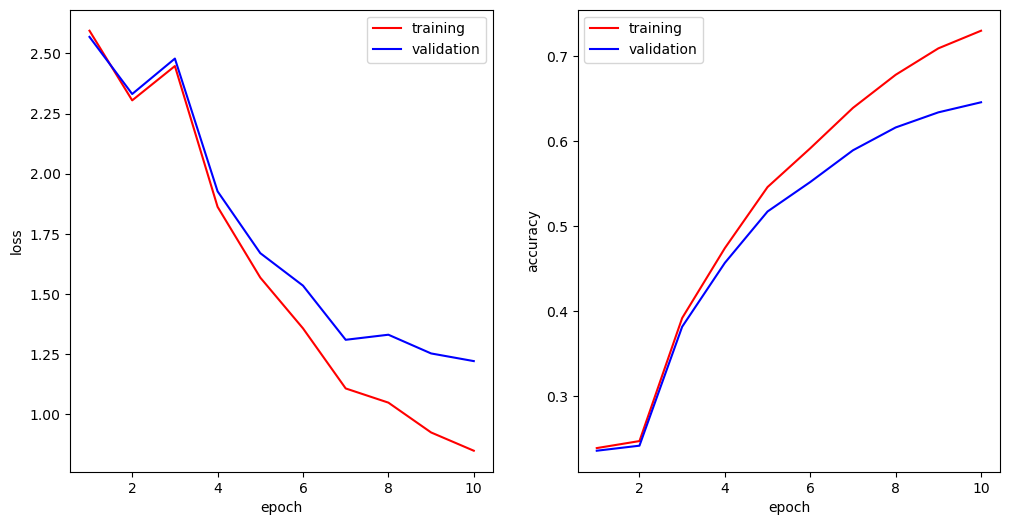

Fold #3
client 1 : 2576 samples
client 2 : 3802 samples
client 3 : 7197 samples
client 4 : 8701 samples
client 5 : 899 samples
client 6 : 2091 samples
client 7 : 3577 samples
client 8 : 11157 samples

>>> Round 1 ...
client 1 : Loss = 0.3750, Accuracy = 0.8824
client 2 : Loss = 0.2011, Accuracy = 0.9317
client 3 : Loss = 0.3757, Accuracy = 0.8939
client 4 : Loss = 0.5246, Accuracy = 0.8165
client 5 : Loss = 0.8230, Accuracy = 0.6888
client 6 : Loss = 0.4788, Accuracy = 0.8126
client 7 : Loss = 0.6536, Accuracy = 0.7781
client 8 : Loss = 0.8292, Accuracy = 0.6686

Server :
    - training loss = 3.1428
    - training accuracy = 0.2481
    - validation loss = 3.1811
    - validation accuracy = 0.2468
        
>>> Round 2 ...
client 1 : Loss = 0.2943, Accuracy = 0.8929
client 2 : Loss = 0.1823, Accuracy = 0.9373
client 3 : Loss = 0.3514, Accuracy = 0.8937
client 4 : Loss = 0.3606, Accuracy = 0.8716
client 5 : Loss = 0.6241, Accuracy = 0.7093
client 6 : Loss = 0.3396, Accuracy = 0.8801
clie

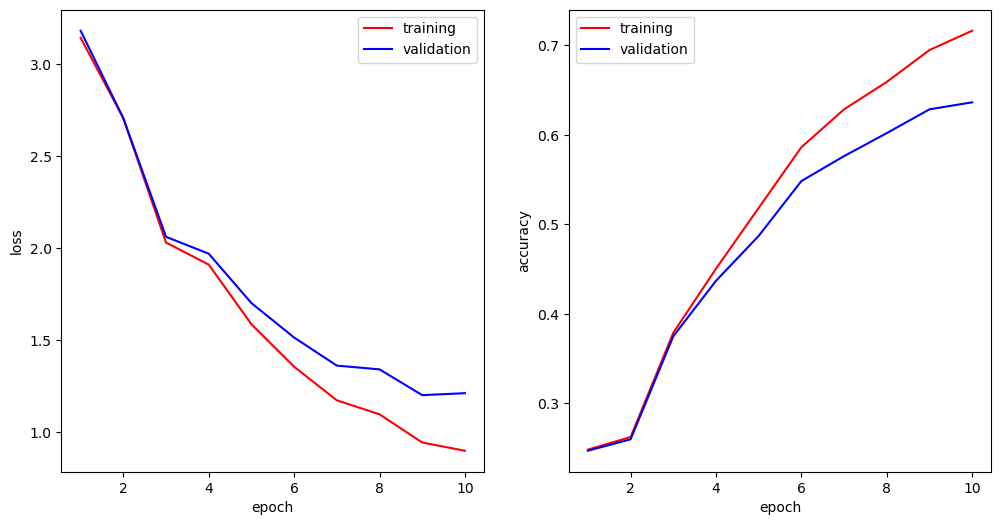

Fold #4
client 1 : 2619 samples
client 2 : 3799 samples
client 3 : 7152 samples
client 4 : 8739 samples
client 5 : 896 samples
client 6 : 2091 samples
client 7 : 3532 samples
client 8 : 11172 samples

>>> Round 1 ...
client 1 : Loss = 0.3130, Accuracy = 0.8954
client 2 : Loss = 0.1961, Accuracy = 0.9421
client 3 : Loss = 0.3607, Accuracy = 0.8917
client 4 : Loss = 0.4114, Accuracy = 0.8548
client 5 : Loss = 0.6533, Accuracy = 0.7478
client 6 : Loss = 0.4894, Accuracy = 0.7842
client 7 : Loss = 0.6311, Accuracy = 0.7820
client 8 : Loss = 0.8115, Accuracy = 0.6772

Server :
    - training loss = 2.9139
    - training accuracy = 0.2586
    - validation loss = 2.9525
    - validation accuracy = 0.2590
        
>>> Round 2 ...
client 1 : Loss = 0.1921, Accuracy = 0.9260
client 2 : Loss = 0.1827, Accuracy = 0.9365
client 3 : Loss = 0.2988, Accuracy = 0.9066
client 4 : Loss = 0.3238, Accuracy = 0.8835
client 5 : Loss = 0.4206, Accuracy = 0.8438
client 6 : Loss = 0.4049, Accuracy = 0.8410
clie

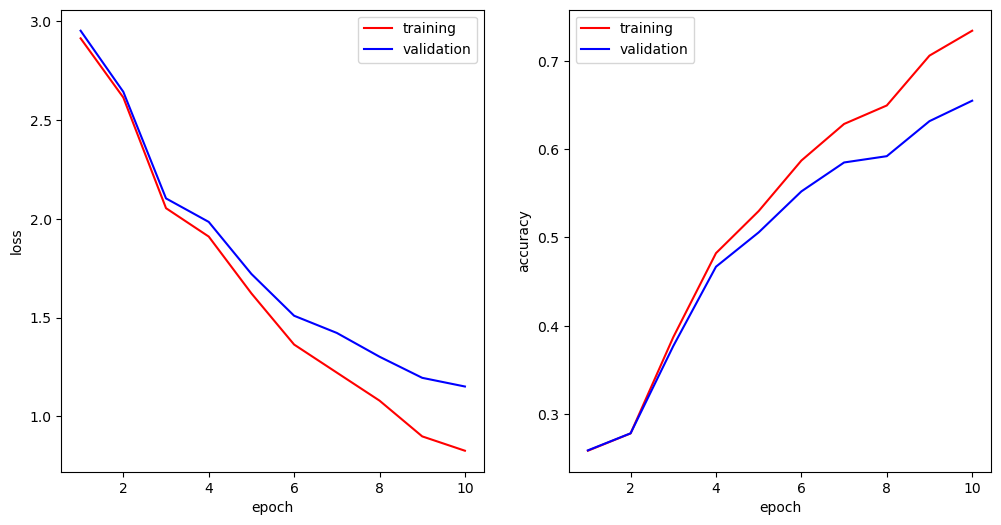

Fold #0
client 1 : 2564 samples
client 2 : 3766 samples
client 3 : 7174 samples
client 4 : 8820 samples
client 5 : 899 samples
client 6 : 2104 samples
client 7 : 3564 samples
client 8 : 11109 samples

>>> Round 1 ...
client 1 : Loss = 0.2974, Accuracy = 0.8839
client 2 : Loss = 0.2032, Accuracy = 0.9352
client 3 : Loss = 0.3307, Accuracy = 0.8975
client 4 : Loss = 0.3861, Accuracy = 0.8596
client 5 : Loss = 0.7475, Accuracy = 0.7181
client 6 : Loss = 0.4035, Accuracy = 0.8545
client 7 : Loss = 0.5832, Accuracy = 0.7973
client 8 : Loss = 0.6852, Accuracy = 0.7342

Server :
    - training loss = 2.3840
    - training accuracy = 0.3021
    - validation loss = 2.3953
    - validation accuracy = 0.2929
        
>>> Round 2 ...
client 1 : Loss = 0.3097, Accuracy = 0.9096
client 2 : Loss = 0.1341, Accuracy = 0.9573
client 3 : Loss = 0.3327, Accuracy = 0.9027
client 4 : Loss = 0.2510, Accuracy = 0.9074
client 5 : Loss = 0.4009, Accuracy = 0.8226
client 6 : Loss = 0.2843, Accuracy = 0.8990
clie

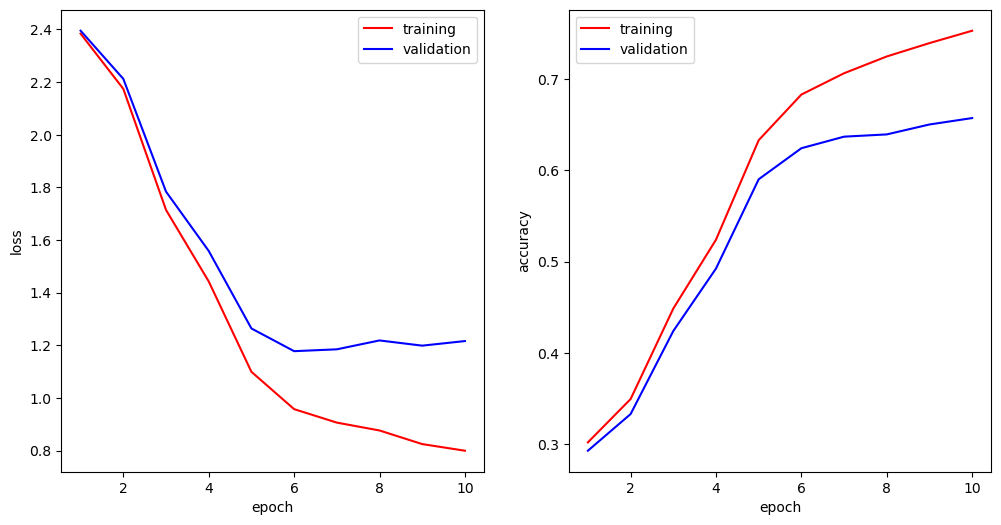

Fold #1
client 1 : 2584 samples
client 2 : 3808 samples
client 3 : 7217 samples
client 4 : 8740 samples
client 5 : 892 samples
client 6 : 2094 samples
client 7 : 3562 samples
client 8 : 11103 samples

>>> Round 1 ...
client 1 : Loss = 0.2098, Accuracy = 0.9196
client 2 : Loss = 0.1891, Accuracy = 0.9382
client 3 : Loss = 0.3181, Accuracy = 0.9000
client 4 : Loss = 0.3912, Accuracy = 0.8587
client 5 : Loss = 0.5866, Accuracy = 0.7635
client 6 : Loss = 0.3900, Accuracy = 0.8441
client 7 : Loss = 0.5530, Accuracy = 0.8146
client 8 : Loss = 0.6998, Accuracy = 0.7269

Server :
    - training loss = 2.4870
    - training accuracy = 0.3202
    - validation loss = 2.4931
    - validation accuracy = 0.3222
        
>>> Round 2 ...
client 1 : Loss = 0.1904, Accuracy = 0.9283
client 2 : Loss = 0.1585, Accuracy = 0.9420
client 3 : Loss = 0.2289, Accuracy = 0.9234
client 4 : Loss = 0.2676, Accuracy = 0.9049
client 5 : Loss = 0.3133, Accuracy = 0.8746
client 6 : Loss = 0.2734, Accuracy = 0.9038
clie

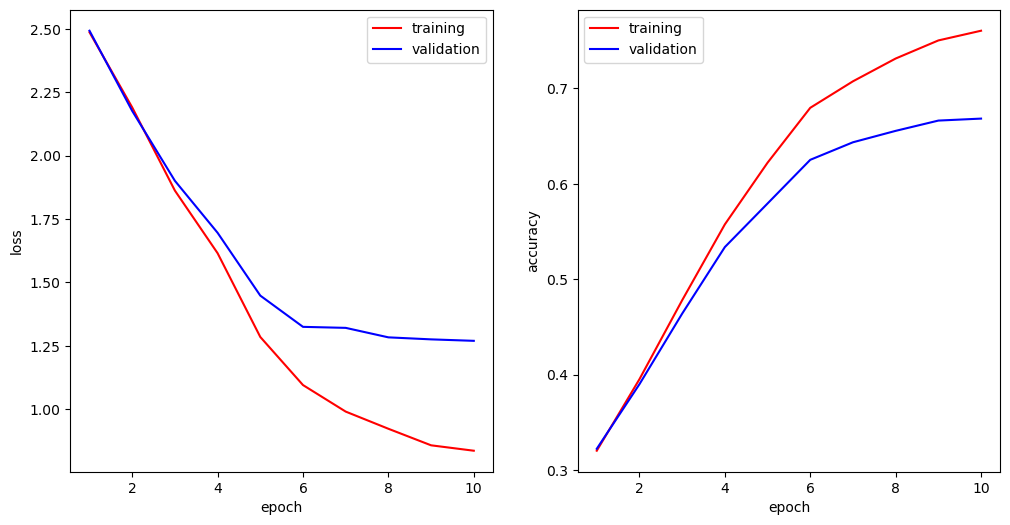

Fold #2
client 1 : 2585 samples
client 2 : 3791 samples
client 3 : 7182 samples
client 4 : 8745 samples
client 5 : 898 samples
client 6 : 2073 samples
client 7 : 3568 samples
client 8 : 11158 samples

>>> Round 1 ...
client 1 : Loss = 0.2110, Accuracy = 0.9214
client 2 : Loss = 0.1770, Accuracy = 0.9408
client 3 : Loss = 0.3037, Accuracy = 0.9053
client 4 : Loss = 0.4002, Accuracy = 0.8600
client 5 : Loss = 0.7702, Accuracy = 0.7129
client 6 : Loss = 0.4209, Accuracy = 0.8376
client 7 : Loss = 0.5662, Accuracy = 0.7968
client 8 : Loss = 0.7146, Accuracy = 0.7216

Server :
    - training loss = 2.5423
    - training accuracy = 0.2999
    - validation loss = 2.5542
    - validation accuracy = 0.3028
        
>>> Round 2 ...
client 1 : Loss = 0.1781, Accuracy = 0.9329
client 2 : Loss = 0.1309, Accuracy = 0.9578
client 3 : Loss = 0.2481, Accuracy = 0.9181
client 4 : Loss = 0.2490, Accuracy = 0.9147
client 5 : Loss = 0.7427, Accuracy = 0.6982
client 6 : Loss = 0.3700, Accuracy = 0.8585
clie

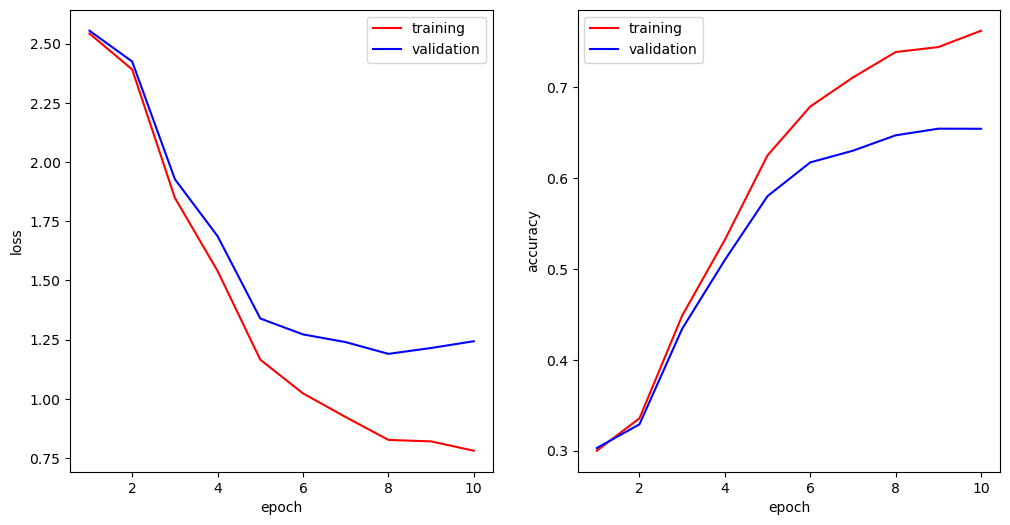

Fold #3
client 1 : 2576 samples
client 2 : 3802 samples
client 3 : 7197 samples
client 4 : 8701 samples
client 5 : 899 samples
client 6 : 2091 samples
client 7 : 3577 samples
client 8 : 11157 samples

>>> Round 1 ...
client 1 : Loss = 0.2303, Accuracy = 0.9118
client 2 : Loss = 0.1830, Accuracy = 0.9432
client 3 : Loss = 0.3289, Accuracy = 0.9028
client 4 : Loss = 0.4054, Accuracy = 0.8507
client 5 : Loss = 0.6331, Accuracy = 0.7627
client 6 : Loss = 0.3846, Accuracy = 0.8549
client 7 : Loss = 0.5439, Accuracy = 0.8041
client 8 : Loss = 0.7212, Accuracy = 0.7178

Server :
    - training loss = 2.6795
    - training accuracy = 0.3166
    - validation loss = 2.6966
    - validation accuracy = 0.3065
        
>>> Round 2 ...
client 1 : Loss = 0.2106, Accuracy = 0.9129
client 2 : Loss = 0.1569, Accuracy = 0.9461
client 3 : Loss = 0.2815, Accuracy = 0.9102
client 4 : Loss = 0.2688, Accuracy = 0.9032
client 5 : Loss = 0.5247, Accuracy = 0.7832
client 6 : Loss = 0.2703, Accuracy = 0.8985
clie

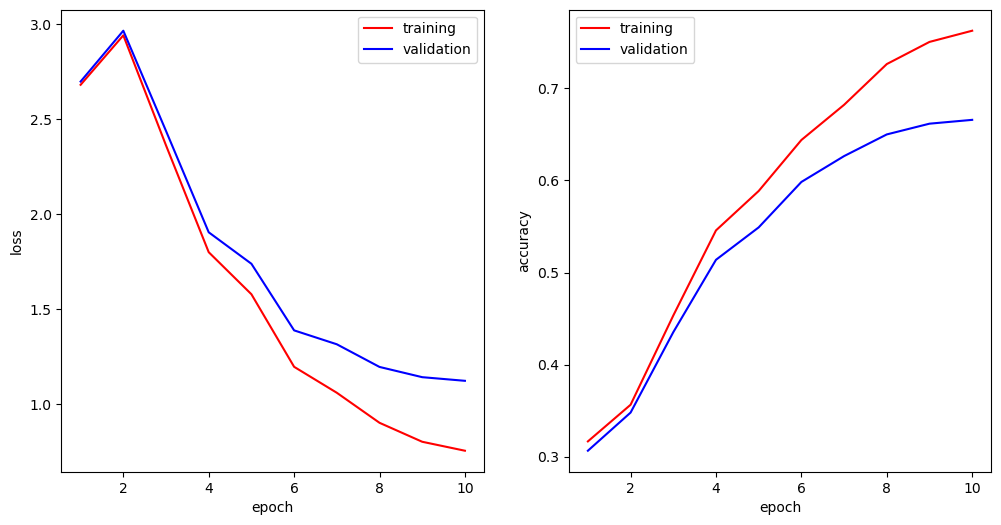

Fold #4
client 1 : 2619 samples
client 2 : 3799 samples
client 3 : 7152 samples
client 4 : 8739 samples
client 5 : 896 samples
client 6 : 2091 samples
client 7 : 3532 samples
client 8 : 11172 samples

>>> Round 1 ...
client 1 : Loss = 0.2226, Accuracy = 0.9093
client 2 : Loss = 0.1582, Accuracy = 0.9477
client 3 : Loss = 0.2724, Accuracy = 0.9137
client 4 : Loss = 0.3545, Accuracy = 0.8774
client 5 : Loss = 0.5724, Accuracy = 0.7723
client 6 : Loss = 0.4246, Accuracy = 0.8498
client 7 : Loss = 0.5597, Accuracy = 0.8051
client 8 : Loss = 0.7443, Accuracy = 0.7090

Server :
    - training loss = 2.5124
    - training accuracy = 0.3301
    - validation loss = 2.5445
    - validation accuracy = 0.3300
        
>>> Round 2 ...
client 1 : Loss = 0.1494, Accuracy = 0.9366
client 2 : Loss = 0.1296, Accuracy = 0.9534
client 3 : Loss = 0.2435, Accuracy = 0.9222
client 4 : Loss = 0.2379, Accuracy = 0.9140
client 5 : Loss = 0.3506, Accuracy = 0.8638
client 6 : Loss = 0.2913, Accuracy = 0.8980
clie

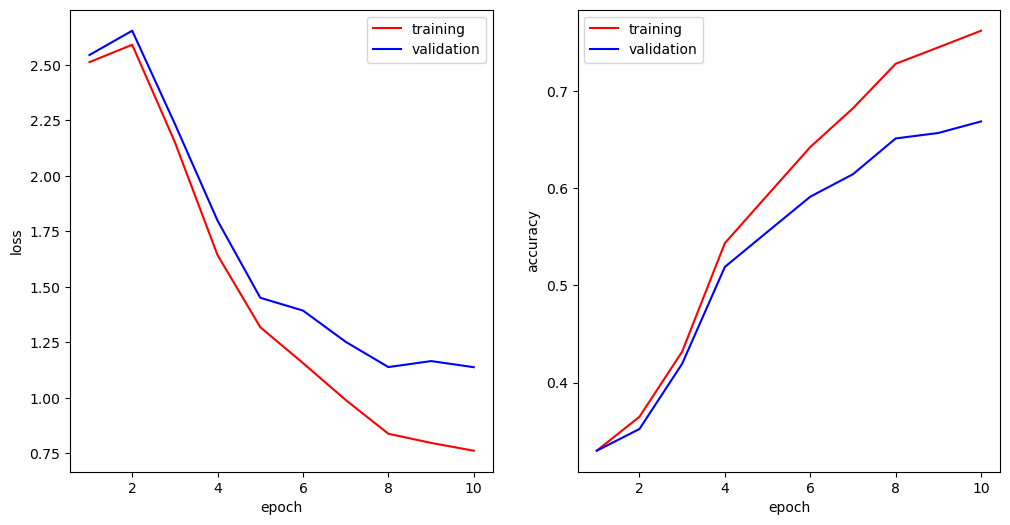

Fold #0
client 1 : 2564 samples
client 2 : 3766 samples
client 3 : 7174 samples
client 4 : 8820 samples
client 5 : 899 samples
client 6 : 2104 samples
client 7 : 3564 samples
client 8 : 11109 samples

>>> Round 1 ...
client 1 : Loss = 0.1672, Accuracy = 0.9315
client 2 : Loss = 0.0728, Accuracy = 0.9738
client 3 : Loss = 0.2098, Accuracy = 0.9280
client 4 : Loss = 0.2445, Accuracy = 0.9151
client 5 : Loss = 0.5183, Accuracy = 0.7757
client 6 : Loss = 0.1468, Accuracy = 0.9518
client 7 : Loss = 0.2824, Accuracy = 0.9027
client 8 : Loss = 0.5684, Accuracy = 0.7766

Server :
    - training loss = 1.9743
    - training accuracy = 0.3506
    - validation loss = 2.0408
    - validation accuracy = 0.3294
        
>>> Round 2 ...
client 1 : Loss = 0.1265, Accuracy = 0.9516
client 2 : Loss = 0.0310, Accuracy = 0.9909
client 3 : Loss = 0.1484, Accuracy = 0.9552
client 4 : Loss = 0.1272, Accuracy = 0.9564
client 5 : Loss = 0.1066, Accuracy = 0.9639
client 6 : Loss = 0.0682, Accuracy = 0.9823
clie

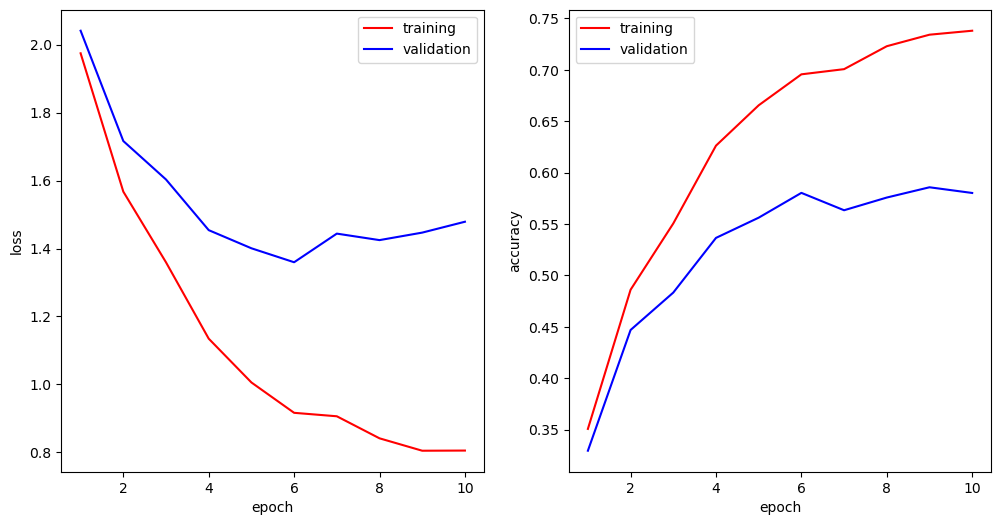

Fold #1
client 1 : 2584 samples
client 2 : 3808 samples
client 3 : 7217 samples
client 4 : 8740 samples
client 5 : 892 samples
client 6 : 2094 samples
client 7 : 3562 samples
client 8 : 11103 samples

>>> Round 1 ...
client 1 : Loss = 0.0652, Accuracy = 0.9781
client 2 : Loss = 0.0765, Accuracy = 0.9713
client 3 : Loss = 0.1793, Accuracy = 0.9429
client 4 : Loss = 0.2425, Accuracy = 0.9126
client 5 : Loss = 0.1248, Accuracy = 0.9675
client 6 : Loss = 0.1744, Accuracy = 0.9372
client 7 : Loss = 0.2879, Accuracy = 0.9066
client 8 : Loss = 0.5732, Accuracy = 0.7785

Server :
    - training loss = 1.8894
    - training accuracy = 0.3735
    - validation loss = 1.9429
    - validation accuracy = 0.3662
        
>>> Round 2 ...
client 1 : Loss = 0.0419, Accuracy = 0.9870
client 2 : Loss = 0.0292, Accuracy = 0.9911
client 3 : Loss = 0.1026, Accuracy = 0.9665
client 4 : Loss = 0.1294, Accuracy = 0.9565
client 5 : Loss = 0.0579, Accuracy = 0.9843
client 6 : Loss = 0.0594, Accuracy = 0.9803
clie

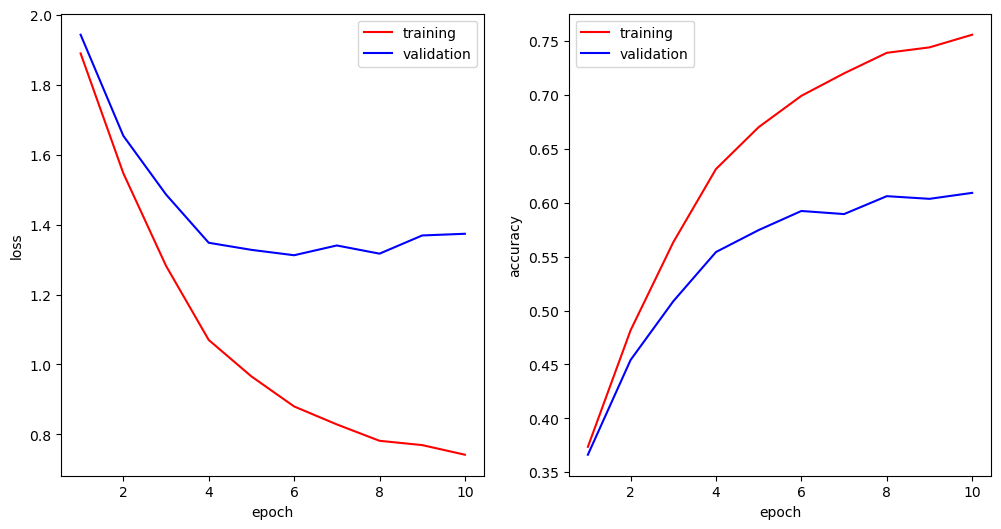

Fold #2
client 1 : 2585 samples
client 2 : 3791 samples
client 3 : 7182 samples
client 4 : 8745 samples
client 5 : 898 samples
client 6 : 2073 samples
client 7 : 3568 samples
client 8 : 11158 samples

>>> Round 1 ...
client 1 : Loss = 0.0810, Accuracy = 0.9699
client 2 : Loss = 0.0667, Accuracy = 0.9774
client 3 : Loss = 0.2013, Accuracy = 0.9326
client 4 : Loss = 0.2403, Accuracy = 0.9145
client 5 : Loss = 0.3645, Accuracy = 0.8564
client 6 : Loss = 0.2298, Accuracy = 0.9181
client 7 : Loss = 0.2979, Accuracy = 0.8973
client 8 : Loss = 0.5913, Accuracy = 0.7707

Server :
    - training loss = 1.9542
    - training accuracy = 0.3980
    - validation loss = 2.0391
    - validation accuracy = 0.3802
        
>>> Round 2 ...
client 1 : Loss = 0.0318, Accuracy = 0.9922
client 2 : Loss = 0.0314, Accuracy = 0.9911
client 3 : Loss = 0.1153, Accuracy = 0.9598
client 4 : Loss = 0.1398, Accuracy = 0.9515
client 5 : Loss = 0.1951, Accuracy = 0.9492
client 6 : Loss = 0.0537, Accuracy = 0.9858
clie

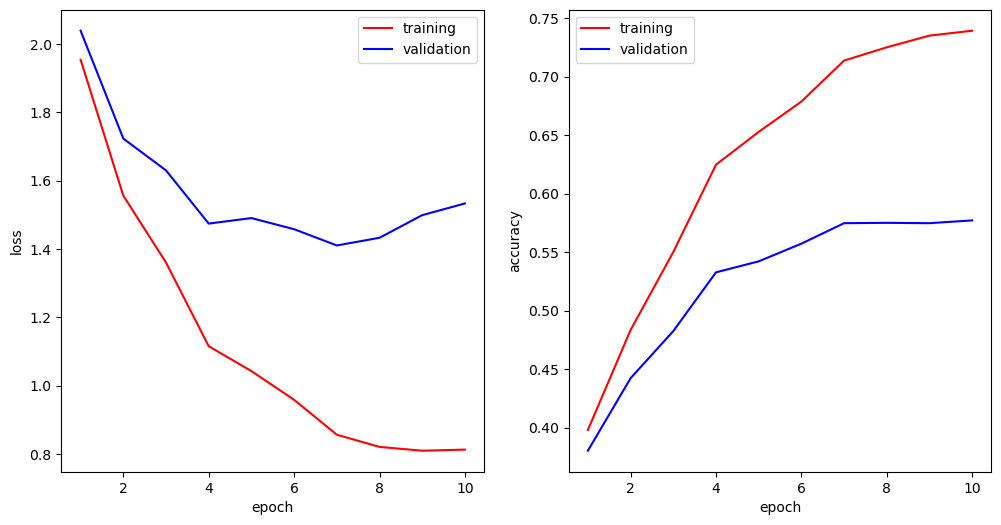

Fold #3
client 1 : 2576 samples
client 2 : 3802 samples
client 3 : 7197 samples
client 4 : 8701 samples
client 5 : 899 samples
client 6 : 2091 samples
client 7 : 3577 samples
client 8 : 11157 samples

>>> Round 1 ...
client 1 : Loss = 0.1173, Accuracy = 0.9602
client 2 : Loss = 0.0611, Accuracy = 0.9783
client 3 : Loss = 0.1744, Accuracy = 0.9408
client 4 : Loss = 0.2250, Accuracy = 0.9201
client 5 : Loss = 0.3967, Accuracy = 0.8525
client 6 : Loss = 0.1584, Accuracy = 0.9439
client 7 : Loss = 0.2748, Accuracy = 0.9060
client 8 : Loss = 0.5875, Accuracy = 0.7761

Server :
    - training loss = 1.8494
    - training accuracy = 0.3992
    - validation loss = 1.9206
    - validation accuracy = 0.3767
        
>>> Round 2 ...
client 1 : Loss = 0.0569, Accuracy = 0.9810
client 2 : Loss = 0.0355, Accuracy = 0.9887
client 3 : Loss = 0.0873, Accuracy = 0.9707
client 4 : Loss = 0.1170, Accuracy = 0.9594
client 5 : Loss = 0.4291, Accuracy = 0.8568
client 6 : Loss = 0.0647, Accuracy = 0.9830
clie

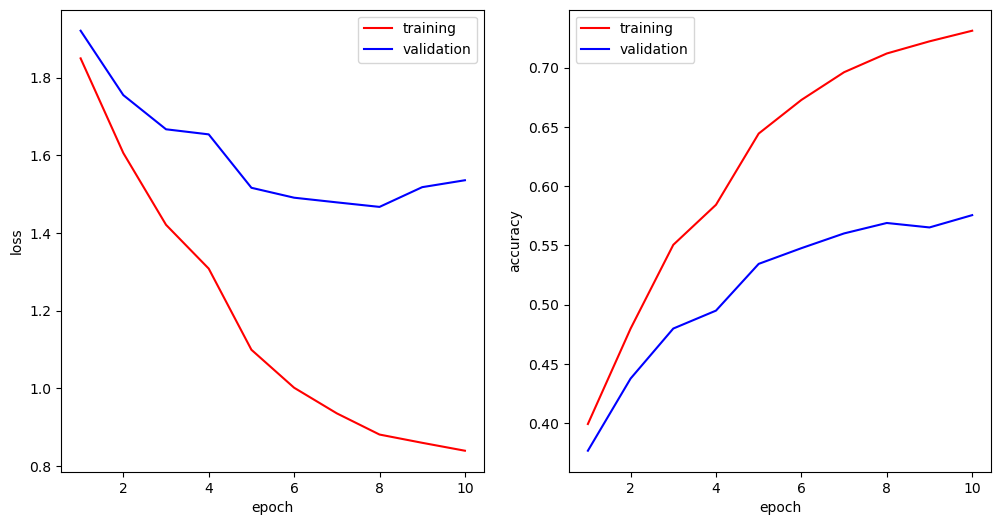

Fold #4
client 1 : 2619 samples
client 2 : 3799 samples
client 3 : 7152 samples
client 4 : 8739 samples
client 5 : 896 samples
client 6 : 2091 samples
client 7 : 3532 samples
client 8 : 11172 samples

>>> Round 1 ...
client 1 : Loss = 0.0947, Accuracy = 0.9635
client 2 : Loss = 0.0732, Accuracy = 0.9728
client 3 : Loss = 0.1756, Accuracy = 0.9407
client 4 : Loss = 0.2414, Accuracy = 0.9143
client 5 : Loss = 0.1336, Accuracy = 0.9587
client 6 : Loss = 0.1913, Accuracy = 0.9334
client 7 : Loss = 0.2876, Accuracy = 0.8995
client 8 : Loss = 0.5879, Accuracy = 0.7701

Server :
    - training loss = 2.0783
    - training accuracy = 0.3654
    - validation loss = 2.1517
    - validation accuracy = 0.3521
        
>>> Round 2 ...
client 1 : Loss = 0.0324, Accuracy = 0.9925
client 2 : Loss = 0.0403, Accuracy = 0.9862
client 3 : Loss = 0.1326, Accuracy = 0.9569
client 4 : Loss = 0.1291, Accuracy = 0.9560
client 5 : Loss = 0.0711, Accuracy = 0.9855
client 6 : Loss = 0.0879, Accuracy = 0.9729
clie

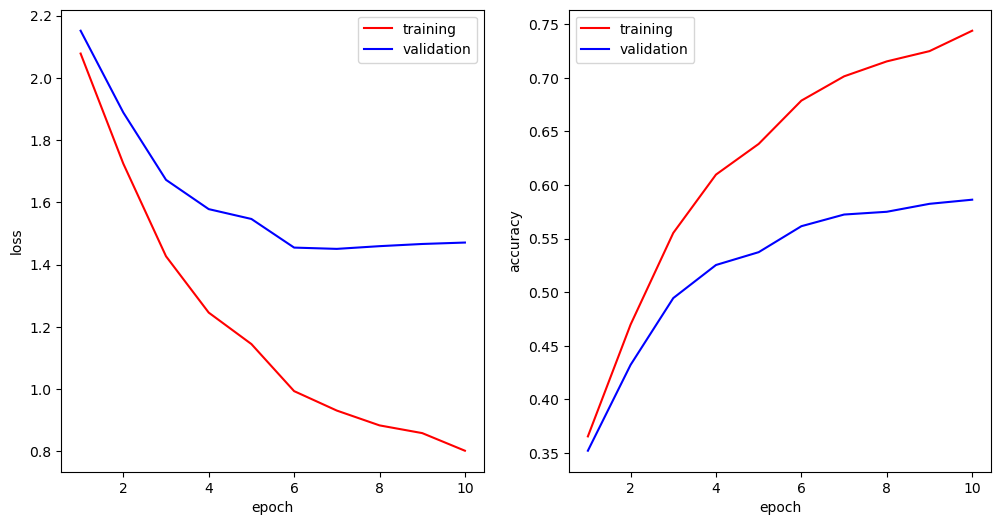

RESULTS
lr = 0.0100 : Accuracy = 0.6444026827812195
lr = 0.0050 : Accuracy = 0.662875771522522
lr = 0.0010 : Accuracy = 0.5856606364250183

CPU times: user 2h 29min 47s, sys: 18.2 s, total: 2h 30min 5s
Wall time: 2h 30min 39s


In [19]:
%%time
n_splits = 5
rounds = 10
batch_size = 128
epochs = 5
lrs = [1e-2,5e-3,1e-3]#[1e-1,1e-2,1e-3,1e-4]
optimizer = optim.Adam

results = []
for lr in lrs:
    res = run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr)
    results.append((lr,res))
    
print("="*25)
print(f"RESULTS")
print("="*25)
for lr,res in results:
    print(f"lr = {lr:.4f} : Accuracy = {res}")
print()


### Summary: Best result achieved with 0.005 learning rate